<a href="https://colab.research.google.com/github/VitalyGladyshev/Python_for_DS/blob/master/hw2_gladyshevvv_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/sample_submission.csv
/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/images.npy
/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/labels.npy
/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/images_sub.npy


In [ ]:
from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [ ]:
import torch

import torchvision

from torch import nn
# from torch import optim

import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

In [ ]:
print(torch.__version__)

2.6.0+cu124


In [ ]:
!nvidia-smi

Sun Jun  1 22:17:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
BATCH_SIZE = 128
EPOCHS = 50
LEARNING_RATE = 0.001
RANDOM_STATE = 42

# Загружаем данные

In [ ]:
train_img = np.load("/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/images.npy")
labels = np.load("/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/labels.npy")
test_img = np.load("/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/images_sub.npy")

In [ ]:
data = pd.read_csv("/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/sample_submission.csv")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Id        50000 non-null  int64
 1   Category  50000 non-null  int64
dtypes: int64(2)
memory usage: 781.4 KB


In [ ]:
data.head()

,Id,Category
0,0,13
1,1,20
2,2,12
3,3,7
4,4,8


In [ ]:
labels

array([13, 24,  8, ..., 21,  7, 18])

In [ ]:
unique_values, counts = np.unique(labels, return_counts=True)
unique_values, counts

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 array([ 748,  878,  710,  880,  764,  677,  816,  904,  440,  497,  794,
         512,  972,  921,  871,  759,  866,  929,  739,  575,  763,  739,
        1013,  816,  682,  735]))

In [ ]:
images = torch.tensor(train_img.astype('float32')/255.0).permute(0,3,1,2)
labels = torch.tensor(labels.astype('int64'))

In [ ]:
images.shape

torch.Size([20000, 3, 48, 48])

In [ ]:
full_train = TensorDataset(images, labels)
full_data_loader = torch.utils.data.DataLoader(dataset=full_train,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(images,
                                                      labels,
                                                      test_size=0.2,
                                                      stratify=labels.numpy(),
                                                      random_state=RANDOM_STATE)

In [ ]:
train_data = TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

valid_data = TensorDataset(X_valid, y_valid)
valid_loader = torch.utils.data.DataLoader(dataset=valid_data,
                                           batch_size=BATCH_SIZE,
                                           shuffle=False)

Метка: U


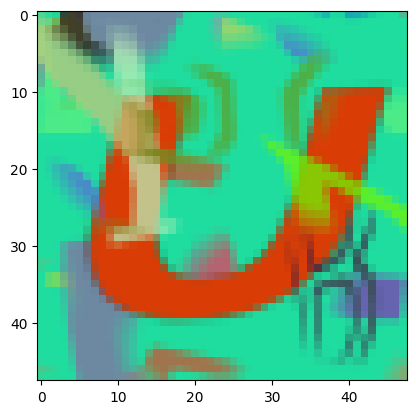

Метка: L


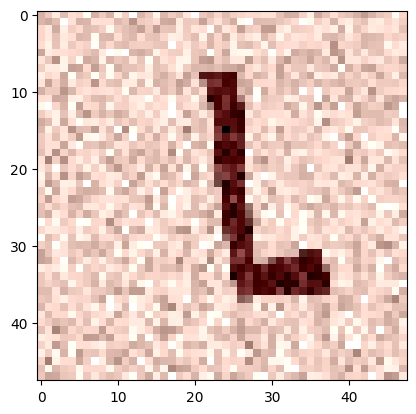

Метка: P


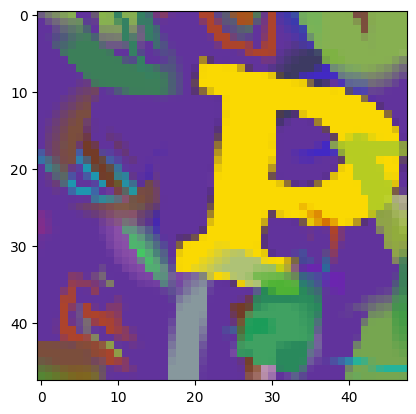

Метка: A


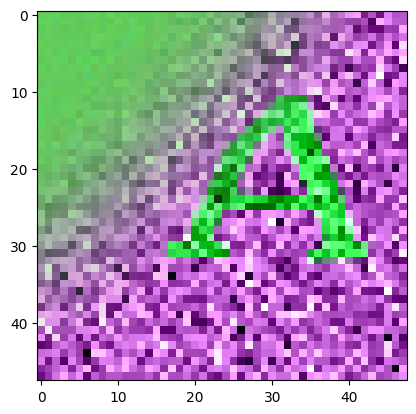

Метка: B


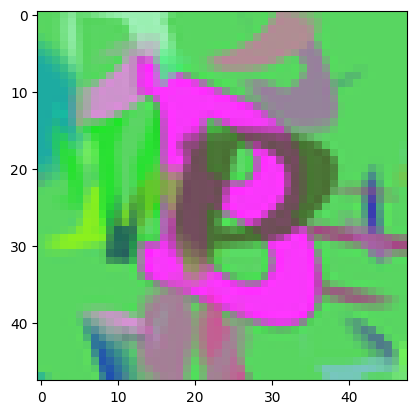

Метка: L


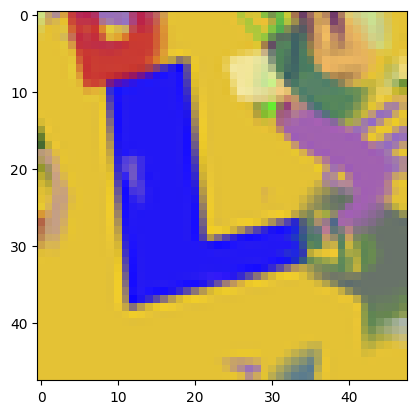

In [ ]:
data_iter = iter(valid_data)

for i in range(6):
    images_c, labels_c = next(data_iter)
    print(f'Метка: {chr(labels_c + 65)}')
    img = torchvision.utils.make_grid(images_c)
    plt.imshow(img.permute(1, 2, 0).numpy())
    plt.show()

## Класс сети

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(256 * 3 * 3, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 26)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = x.view(-1, 256 * 3 * 3)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

## Обучение сети

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

In [ ]:
best_val_acc = 0.0
patience_counter = 0
patience = 5

for epoch in range(1, EPOCHS + 1):
    # Обучение
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch}/50 [Train]'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    avg_train_loss = train_acc / len(train_loader)

    # Валидация
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f'Epoch {epoch}/50 [Valid]'):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = 100. * correct / total
    avg_val_loss = val_loss / len(valid_loader)

    print(f'Эпоха {epoch}: '
          f'Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.2f}% | '
          f'Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.2f}%')

    # Ранняя остановка
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Ранняя остановка после {epoch} эпох')
            break

Epoch 1/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 156.92it/s]


Эпоха 1: Train Loss: 0.0401, Acc: 5.02% | Val Loss: 3.2010, Acc: 7.03%


Epoch 2/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 170.04it/s]


Эпоха 2: Train Loss: 0.1042, Acc: 13.03% | Val Loss: 2.3738, Acc: 30.62%


Epoch 3/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 168.75it/s]


Эпоха 3: Train Loss: 0.2633, Acc: 32.91% | Val Loss: 1.5747, Acc: 51.30%


Epoch 4/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 169.48it/s]


Эпоха 4: Train Loss: 0.3889, Acc: 48.62% | Val Loss: 1.1009, Acc: 63.92%


Epoch 5/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 169.06it/s]


Эпоха 5: Train Loss: 0.4671, Acc: 58.39% | Val Loss: 0.8671, Acc: 73.17%


Epoch 6/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 168.97it/s]


Эпоха 6: Train Loss: 0.5272, Acc: 65.89% | Val Loss: 0.8205, Acc: 74.62%


Epoch 7/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 169.05it/s]


Эпоха 7: Train Loss: 0.5632, Acc: 70.40% | Val Loss: 0.6777, Acc: 78.58%


Epoch 8/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 163.45it/s]


Эпоха 8: Train Loss: 0.5917, Acc: 73.97% | Val Loss: 0.6200, Acc: 80.25%


Epoch 9/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 170.49it/s]


Эпоха 9: Train Loss: 0.6145, Acc: 76.81% | Val Loss: 0.6221, Acc: 80.40%


Epoch 10/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 168.95it/s]


Эпоха 10: Train Loss: 0.6308, Acc: 78.84% | Val Loss: 0.6266, Acc: 80.40%


Epoch 11/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 170.64it/s]


Эпоха 11: Train Loss: 0.6464, Acc: 80.80% | Val Loss: 0.6780, Acc: 79.22%


Epoch 12/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 169.61it/s]


Эпоха 12: Train Loss: 0.6615, Acc: 82.68% | Val Loss: 0.5502, Acc: 83.12%


Epoch 13/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 163.17it/s]


Эпоха 13: Train Loss: 0.6700, Acc: 83.75% | Val Loss: 0.5216, Acc: 83.55%


Epoch 14/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 169.33it/s]


Эпоха 14: Train Loss: 0.6879, Acc: 85.99% | Val Loss: 0.5462, Acc: 83.38%


Epoch 15/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 169.17it/s]


Эпоха 15: Train Loss: 0.6900, Acc: 86.24% | Val Loss: 0.5812, Acc: 82.35%


Epoch 16/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 168.26it/s]


Эпоха 16: Train Loss: 0.6922, Acc: 86.53% | Val Loss: 0.4820, Acc: 84.58%


Epoch 17/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 167.56it/s]


Эпоха 17: Train Loss: 0.7041, Acc: 88.02% | Val Loss: 0.5402, Acc: 83.90%


Epoch 18/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 168.32it/s]


Эпоха 18: Train Loss: 0.7160, Acc: 89.49% | Val Loss: 0.5498, Acc: 84.35%


Epoch 19/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 169.66it/s]


Эпоха 19: Train Loss: 0.7167, Acc: 89.58% | Val Loss: 0.5738, Acc: 83.38%


Epoch 20/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 167.89it/s]


Эпоха 20: Train Loss: 0.7182, Acc: 89.78% | Val Loss: 0.5416, Acc: 84.47%


Epoch 21/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 164.97it/s]

Эпоха 21: Train Loss: 0.7272, Acc: 90.91% | Val Loss: 0.5705, Acc: 83.92%
Ранняя остановка после 21 эпох


## Обучаем на полных данных

In [ ]:
model_f = CNN().to(device)
criterion_f = nn.CrossEntropyLoss()
optimizer_f = optim.Adam(model_f.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

In [ ]:
best_acc = 0

for epoch in range(1, 40 + 1):
    # Обучение
    model_f.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(full_data_loader, desc=f'Epoch {epoch}/40 [Train]'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_f.zero_grad()
        outputs = model_f(inputs)
        loss = criterion_f(outputs, labels)
        loss.backward()
        optimizer_f.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    avg_train_loss = train_acc / len(train_loader)

    print(f'Epoch {epoch}: '
          f'Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.2f}%')

    if train_acc > best_acc:
        best_acc = train_acc
        torch.save(model_f.state_dict(), 'best_model_f.pth')

Epoch 1/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 69.65it/s]


Epoch 1: Train Loss: 0.0445, Acc: 5.56%


Epoch 2/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 70.62it/s]


Epoch 2: Train Loss: 0.1246, Acc: 15.57%


Epoch 3/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 70.44it/s]


Epoch 3: Train Loss: 0.2842, Acc: 35.52%


Epoch 4/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 70.55it/s]


Epoch 4: Train Loss: 0.3930, Acc: 49.12%


Epoch 5/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 69.83it/s]


Epoch 5: Train Loss: 0.4589, Acc: 57.36%


Epoch 6/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 70.60it/s]


Epoch 6: Train Loss: 0.5104, Acc: 63.80%


Epoch 7/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 70.42it/s]


Epoch 7: Train Loss: 0.5376, Acc: 67.20%


Epoch 8/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 70.43it/s]


Epoch 8: Train Loss: 0.5662, Acc: 70.78%


Epoch 9/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 70.45it/s]


Epoch 9: Train Loss: 0.5836, Acc: 72.95%


Epoch 10/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 70.26it/s]


Epoch 10: Train Loss: 0.6019, Acc: 75.23%


Epoch 11/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 70.67it/s]


Epoch 11: Train Loss: 0.6129, Acc: 76.61%


Epoch 12/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 70.35it/s]


Epoch 12: Train Loss: 0.6244, Acc: 78.05%


Epoch 13/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 70.43it/s]


Epoch 13: Train Loss: 0.6398, Acc: 79.97%


Epoch 14/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 70.46it/s]


Epoch 14: Train Loss: 0.6495, Acc: 81.19%


Epoch 15/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 70.46it/s]


Epoch 15: Train Loss: 0.6605, Acc: 82.56%


Epoch 16/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 70.32it/s]


Epoch 16: Train Loss: 0.6650, Acc: 83.13%


Epoch 17/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 70.65it/s]


Epoch 17: Train Loss: 0.6723, Acc: 84.04%


Epoch 18/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 70.49it/s]


Epoch 18: Train Loss: 0.6853, Acc: 85.66%


Epoch 19/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 69.93it/s]


Epoch 19: Train Loss: 0.6834, Acc: 85.43%


Epoch 20/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 70.17it/s]


Epoch 20: Train Loss: 0.6936, Acc: 86.70%


Epoch 21/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 70.42it/s]


Epoch 21: Train Loss: 0.6980, Acc: 87.25%


Epoch 22/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 70.41it/s]


Epoch 22: Train Loss: 0.7018, Acc: 87.72%


Epoch 23/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 70.40it/s]


Epoch 23: Train Loss: 0.7001, Acc: 87.52%


Epoch 24/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 70.36it/s]


Epoch 24: Train Loss: 0.7116, Acc: 88.94%


Epoch 25/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 69.92it/s]


Epoch 25: Train Loss: 0.7195, Acc: 89.94%


Epoch 26/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 70.56it/s]


Epoch 26: Train Loss: 0.7114, Acc: 88.92%


Epoch 27/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 70.41it/s]


Epoch 27: Train Loss: 0.7230, Acc: 90.37%


Epoch 28/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 70.51it/s]


Epoch 28: Train Loss: 0.7203, Acc: 90.04%


Epoch 29/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 70.36it/s]


Epoch 29: Train Loss: 0.7250, Acc: 90.63%


Epoch 30/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 70.70it/s]


Epoch 30: Train Loss: 0.7274, Acc: 90.92%


Epoch 31/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 70.52it/s]


Epoch 31: Train Loss: 0.7371, Acc: 92.14%


Epoch 32/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 70.60it/s]


Epoch 32: Train Loss: 0.7349, Acc: 91.86%


Epoch 33/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 69.52it/s]


Epoch 33: Train Loss: 0.7350, Acc: 91.88%


Epoch 34/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 70.25it/s]


Epoch 34: Train Loss: 0.7388, Acc: 92.35%


Epoch 35/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 70.41it/s]


Epoch 35: Train Loss: 0.7402, Acc: 92.53%


Epoch 36/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 70.36it/s]


Epoch 36: Train Loss: 0.7438, Acc: 92.98%


Epoch 37/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 69.66it/s]


Epoch 37: Train Loss: 0.7480, Acc: 93.50%


Epoch 38/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 69.60it/s]


Epoch 38: Train Loss: 0.7476, Acc: 93.45%


Epoch 39/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 70.18it/s]


Epoch 39: Train Loss: 0.7471, Acc: 93.39%


Epoch 40/40 [Train]: 100%|██████████| 157/157 [00:02<00:00, 70.07it/s]

Epoch 40: Train Loss: 0.7468, Acc: 93.36%


## Предсказание для submission

In [ ]:
images_subm = torch.tensor(test_img.astype('float32')/255.0).permute(0,3,1,2)

In [ ]:
test_data_loader = torch.utils.data.DataLoader(dataset=images_subm,
                                               batch_size=BATCH_SIZE,
                                               shuffle=False)

In [ ]:
model_f.eval()
prediction = []

with torch.no_grad():
    for inputs in tqdm(test_data_loader):
        inputs = inputs.to(device)

        outputs = model_f(inputs)
        _, predicted = outputs.max(1)
        prediction.extend(predicted.cpu().tolist())

100%|██████████| 391/391 [00:02<00:00, 182.45it/s]


In [ ]:
prediction[:10]

[21, 24, 3, 12, 10, 7, 5, 17, 23, 22]

In [ ]:
submission = pd.DataFrame({
    'id': np.arange(len(prediction)),
    'Category': prediction
})
submission.to_csv('submission.csv', index=False)

## Вариант с ResidualBlock

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return F.relu(out)

class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=26):
        super().__init__()
        self.in_channels = 64

        # Начальный слой
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Residual блоки
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        # Глобальный пулинг и классификатор
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes))

    def _make_layer(self, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
model_r = ImprovedCNN().to(device)
criterion_r = nn.CrossEntropyLoss()
optimizer_r = optim.Adam(model_r.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

In [ ]:
best_val_acc = 0.0
patience_counter = 0
patience = 5

for epoch in range(1, 60 + 1):
    # Обучение
    model_r.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch}/50 [Train]'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_r.zero_grad()
        outputs = model_r(inputs)
        loss = criterion_r(outputs, labels)
        loss.backward()
        optimizer_r.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    avg_train_loss = train_acc / len(train_loader)

    # Валидация
    model_r.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f'Epoch {epoch}/50 [Valid]'):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model_r(inputs)
            loss = criterion_r(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = 100. * correct / total
    avg_val_loss = val_loss / len(valid_loader)

    print(f'Эпоха {epoch}: '
          f'Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.2f}% | '
          f'Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.2f}%')

    # Ранняя остановка
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model_r.state_dict(), 'best_model_r.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Ранняя остановка после {epoch} эпох')
            break

Epoch 1/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 96.89it/s]


Эпоха 1: Train Loss: 0.0370, Acc: 4.62% | Val Loss: 3.2060, Acc: 6.47%


Epoch 2/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.75it/s]


Эпоха 2: Train Loss: 0.1192, Acc: 14.91% | Val Loss: 2.1884, Acc: 34.15%


Epoch 3/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 101.07it/s]


Эпоха 3: Train Loss: 0.4084, Acc: 51.06% | Val Loss: 1.2138, Acc: 62.00%


Epoch 4/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 98.81it/s]


Эпоха 4: Train Loss: 0.5925, Acc: 74.07% | Val Loss: 0.8079, Acc: 74.53%


Epoch 5/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.94it/s]


Эпоха 5: Train Loss: 0.6660, Acc: 83.25% | Val Loss: 0.9290, Acc: 72.75%


Epoch 6/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 101.08it/s]


Эпоха 6: Train Loss: 0.7002, Acc: 87.53% | Val Loss: 0.7935, Acc: 76.42%


Epoch 7/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 99.55it/s]


Эпоха 7: Train Loss: 0.7246, Acc: 90.58% | Val Loss: 0.4894, Acc: 85.47%


Epoch 8/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 101.04it/s]


Эпоха 8: Train Loss: 0.7336, Acc: 91.70% | Val Loss: 0.6446, Acc: 81.45%


Epoch 9/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 101.45it/s]


Эпоха 9: Train Loss: 0.7507, Acc: 93.84% | Val Loss: 0.4412, Acc: 86.92%


Epoch 10/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.45it/s]


Эпоха 10: Train Loss: 0.7614, Acc: 95.17% | Val Loss: 0.4958, Acc: 86.15%


Epoch 11/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 101.45it/s]


Эпоха 11: Train Loss: 0.7683, Acc: 96.04% | Val Loss: 0.4586, Acc: 87.30%


Epoch 12/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.53it/s]


Эпоха 12: Train Loss: 0.7758, Acc: 96.97% | Val Loss: 0.5000, Acc: 87.03%


Epoch 13/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.69it/s]


Эпоха 13: Train Loss: 0.7732, Acc: 96.65% | Val Loss: 0.5335, Acc: 86.15%


Epoch 14/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.99it/s]


Эпоха 14: Train Loss: 0.7726, Acc: 96.58% | Val Loss: 0.5206, Acc: 86.78%


Epoch 15/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 98.23it/s]


Эпоха 15: Train Loss: 0.7799, Acc: 97.49% | Val Loss: 0.5286, Acc: 86.80%


Epoch 16/50 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 101.05it/s]

Эпоха 16: Train Loss: 0.7809, Acc: 97.61% | Val Loss: 0.4815, Acc: 87.22%
Ранняя остановка после 16 эпох


## Добавим аугментацию

### Базовый вариант модели

In [ ]:
# Аугментации для тренировочных данных
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

# Обертка для Dataset с аугментацией
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, tensor_data, tensor_labels, transform=None):
        self.data = tensor_data
        self.labels = tensor_labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# Создание DataLoader с аугментацией
train_data_aug = AugmentedDataset(X_train, y_train, transform=train_transform)
train_loader_aug = torch.utils.data.DataLoader(train_data_aug, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
model_ba = CNN().to(device)
criterion_ba = nn.CrossEntropyLoss()
optimizer_ba = optim.Adam(model_ba.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

In [ ]:
best_val_acc = 0.0
patience_counter = 0
patience = 10
EPOCHS_C = 80

for epoch in range(1, EPOCHS_C + 1):
    # Обучение
    model_ba.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader_aug, desc=f'Epoch {epoch}/{EPOCHS_C} [Train]'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_ba.zero_grad()
        outputs = model_ba(inputs)
        loss = criterion_ba(outputs, labels)
        loss.backward()
        optimizer_ba.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    avg_train_loss = train_acc / len(train_loader)

    # Валидация
    model_ba.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f'Epoch {epoch}/{EPOCHS_C} [Valid]'):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model_ba(inputs)
            loss = criterion_ba(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = 100. * correct / total
    avg_val_loss = val_loss / len(valid_loader)

    print(f'Эпоха {epoch}: '
          f'Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.2f}% | '
          f'Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.2f}%')

    # Ранняя остановка
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model_ba.state_dict(), 'best_model_ba.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Ранняя остановка после {epoch} эпох')
            break

Epoch 1/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 156.17it/s]


Эпоха 1: Train Loss: 0.0372, Acc: 4.65% | Val Loss: 3.2267, Acc: 5.65%


Epoch 2/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 160.85it/s]


Эпоха 2: Train Loss: 0.0519, Acc: 6.49% | Val Loss: 3.0880, Acc: 8.18%


Epoch 3/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 162.58it/s]


Эпоха 3: Train Loss: 0.0718, Acc: 8.98% | Val Loss: 2.9106, Acc: 11.62%


Epoch 4/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 161.31it/s]


Эпоха 4: Train Loss: 0.1083, Acc: 13.54% | Val Loss: 2.5021, Acc: 20.18%


Epoch 5/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 168.13it/s]


Эпоха 5: Train Loss: 0.1541, Acc: 19.26% | Val Loss: 2.3451, Acc: 23.55%


Epoch 6/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 162.38it/s]


Эпоха 6: Train Loss: 0.1987, Acc: 24.84% | Val Loss: 2.0705, Acc: 34.02%


Epoch 7/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 162.72it/s]


Эпоха 7: Train Loss: 0.2262, Acc: 28.27% | Val Loss: 1.7484, Acc: 42.33%


Epoch 8/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 168.50it/s]


Эпоха 8: Train Loss: 0.2563, Acc: 32.04% | Val Loss: 1.6392, Acc: 46.92%


Epoch 9/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 168.02it/s]


Эпоха 9: Train Loss: 0.2873, Acc: 35.91% | Val Loss: 1.4395, Acc: 54.77%


Epoch 10/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 162.15it/s]


Эпоха 10: Train Loss: 0.3069, Acc: 38.36% | Val Loss: 1.3866, Acc: 54.67%


Epoch 11/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 159.69it/s]


Эпоха 11: Train Loss: 0.3198, Acc: 39.98% | Val Loss: 1.2555, Acc: 58.23%


Epoch 12/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 165.63it/s]


Эпоха 12: Train Loss: 0.3357, Acc: 41.97% | Val Loss: 1.2060, Acc: 60.95%


Epoch 13/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 165.16it/s]


Эпоха 13: Train Loss: 0.3549, Acc: 44.37% | Val Loss: 1.2108, Acc: 61.08%


Epoch 14/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 159.34it/s]


Эпоха 14: Train Loss: 0.3674, Acc: 45.93% | Val Loss: 1.1504, Acc: 63.02%


Epoch 15/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 164.84it/s]


Эпоха 15: Train Loss: 0.3747, Acc: 46.84% | Val Loss: 1.1348, Acc: 63.70%


Epoch 16/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 156.10it/s]


Эпоха 16: Train Loss: 0.3857, Acc: 48.21% | Val Loss: 1.0839, Acc: 66.25%


Epoch 17/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 155.24it/s]


Эпоха 17: Train Loss: 0.3991, Acc: 49.88% | Val Loss: 1.0656, Acc: 65.38%


Epoch 18/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 150.60it/s]


Эпоха 18: Train Loss: 0.4011, Acc: 50.13% | Val Loss: 1.0205, Acc: 68.58%


Epoch 19/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 157.92it/s]


Эпоха 19: Train Loss: 0.4181, Acc: 52.26% | Val Loss: 0.9812, Acc: 69.75%


Epoch 20/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 163.92it/s]


Эпоха 20: Train Loss: 0.4214, Acc: 52.67% | Val Loss: 0.9383, Acc: 71.95%


Epoch 21/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 169.35it/s]


Эпоха 21: Train Loss: 0.4251, Acc: 53.13% | Val Loss: 0.9267, Acc: 69.42%


Epoch 22/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 155.50it/s]


Эпоха 22: Train Loss: 0.4359, Acc: 54.49% | Val Loss: 1.0523, Acc: 67.40%


Epoch 23/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 160.39it/s]


Эпоха 23: Train Loss: 0.4380, Acc: 54.74% | Val Loss: 0.8833, Acc: 72.72%


Epoch 24/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 164.07it/s]


Эпоха 24: Train Loss: 0.4441, Acc: 55.52% | Val Loss: 0.8928, Acc: 72.85%


Epoch 25/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 169.29it/s]


Эпоха 25: Train Loss: 0.4581, Acc: 57.26% | Val Loss: 0.8586, Acc: 74.25%


Epoch 26/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 159.08it/s]


Эпоха 26: Train Loss: 0.4596, Acc: 57.44% | Val Loss: 0.8468, Acc: 73.17%


Epoch 27/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 165.35it/s]


Эпоха 27: Train Loss: 0.4664, Acc: 58.30% | Val Loss: 0.8753, Acc: 72.62%


Epoch 28/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 170.84it/s]


Эпоха 28: Train Loss: 0.4609, Acc: 57.61% | Val Loss: 0.8860, Acc: 70.25%


Epoch 29/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 167.52it/s]


Эпоха 29: Train Loss: 0.4734, Acc: 59.17% | Val Loss: 0.8583, Acc: 74.70%


Epoch 30/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 162.88it/s]


Эпоха 30: Train Loss: 0.4756, Acc: 59.46% | Val Loss: 0.8711, Acc: 75.12%


Epoch 31/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 169.07it/s]


Эпоха 31: Train Loss: 0.4841, Acc: 60.52% | Val Loss: 0.8184, Acc: 74.80%


Epoch 32/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 168.64it/s]


Эпоха 32: Train Loss: 0.4864, Acc: 60.79% | Val Loss: 0.7589, Acc: 77.90%


Epoch 33/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 169.76it/s]


Эпоха 33: Train Loss: 0.4909, Acc: 61.36% | Val Loss: 0.7331, Acc: 78.35%


Epoch 34/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 165.52it/s]


Эпоха 34: Train Loss: 0.4940, Acc: 61.75% | Val Loss: 0.7646, Acc: 79.03%


Epoch 35/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 170.27it/s]


Эпоха 35: Train Loss: 0.4973, Acc: 62.16% | Val Loss: 0.8956, Acc: 74.55%


Epoch 36/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 168.16it/s]


Эпоха 36: Train Loss: 0.5062, Acc: 63.27% | Val Loss: 0.7618, Acc: 78.12%


Epoch 37/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 170.70it/s]


Эпоха 37: Train Loss: 0.5074, Acc: 63.43% | Val Loss: 0.7553, Acc: 76.55%


Epoch 38/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 165.15it/s]


Эпоха 38: Train Loss: 0.5135, Acc: 64.18% | Val Loss: 0.7339, Acc: 79.10%


Epoch 39/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 171.15it/s]


Эпоха 39: Train Loss: 0.5245, Acc: 65.56% | Val Loss: 0.7234, Acc: 78.17%


Epoch 40/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 170.71it/s]


Эпоха 40: Train Loss: 0.5236, Acc: 65.45% | Val Loss: 0.7390, Acc: 79.62%


Epoch 41/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 169.91it/s]


Эпоха 41: Train Loss: 0.5269, Acc: 65.86% | Val Loss: 0.6887, Acc: 79.05%


Epoch 42/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 163.67it/s]


Эпоха 42: Train Loss: 0.5324, Acc: 66.55% | Val Loss: 0.6529, Acc: 79.85%


Epoch 43/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 169.47it/s]


Эпоха 43: Train Loss: 0.5345, Acc: 66.81% | Val Loss: 0.6648, Acc: 82.00%


Epoch 44/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 170.53it/s]


Эпоха 44: Train Loss: 0.5395, Acc: 67.43% | Val Loss: 0.6511, Acc: 78.83%


Epoch 45/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 169.70it/s]


Эпоха 45: Train Loss: 0.5462, Acc: 68.28% | Val Loss: 0.6675, Acc: 79.53%


Epoch 46/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 163.69it/s]


Эпоха 46: Train Loss: 0.5503, Acc: 68.78% | Val Loss: 0.6480, Acc: 79.75%


Epoch 47/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 170.05it/s]


Эпоха 47: Train Loss: 0.5603, Acc: 70.03% | Val Loss: 0.6558, Acc: 79.42%


Epoch 48/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 169.80it/s]


Эпоха 48: Train Loss: 0.5598, Acc: 69.97% | Val Loss: 0.6021, Acc: 81.97%


Epoch 49/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 171.73it/s]


Эпоха 49: Train Loss: 0.5680, Acc: 70.99% | Val Loss: 0.5831, Acc: 83.33%


Epoch 50/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 163.11it/s]


Эпоха 50: Train Loss: 0.5743, Acc: 71.78% | Val Loss: 0.6718, Acc: 78.70%


Epoch 51/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 170.32it/s]


Эпоха 51: Train Loss: 0.5763, Acc: 72.03% | Val Loss: 0.5769, Acc: 82.45%


Epoch 52/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 167.81it/s]


Эпоха 52: Train Loss: 0.5847, Acc: 73.08% | Val Loss: 0.5782, Acc: 80.30%


Epoch 53/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 171.39it/s]


Эпоха 53: Train Loss: 0.5920, Acc: 73.99% | Val Loss: 0.5459, Acc: 82.38%


Epoch 54/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 165.42it/s]


Эпоха 54: Train Loss: 0.5907, Acc: 73.84% | Val Loss: 0.5891, Acc: 81.00%


Epoch 55/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 170.03it/s]


Эпоха 55: Train Loss: 0.5952, Acc: 74.41% | Val Loss: 0.5317, Acc: 84.12%


Epoch 56/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 170.31it/s]


Эпоха 56: Train Loss: 0.6000, Acc: 75.00% | Val Loss: 0.5453, Acc: 83.90%


Epoch 57/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 170.45it/s]


Эпоха 57: Train Loss: 0.6020, Acc: 75.26% | Val Loss: 0.5033, Acc: 84.85%


Epoch 58/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 164.34it/s]


Эпоха 58: Train Loss: 0.6131, Acc: 76.64% | Val Loss: 0.4937, Acc: 85.70%


Epoch 59/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 167.02it/s]


Эпоха 59: Train Loss: 0.6121, Acc: 76.51% | Val Loss: 0.5090, Acc: 84.60%


Epoch 60/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 169.10it/s]


Эпоха 60: Train Loss: 0.6135, Acc: 76.68% | Val Loss: 0.4877, Acc: 84.72%


Epoch 61/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 169.36it/s]


Эпоха 61: Train Loss: 0.6181, Acc: 77.26% | Val Loss: 0.4937, Acc: 84.95%


Epoch 62/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 164.60it/s]


Эпоха 62: Train Loss: 0.6256, Acc: 78.20% | Val Loss: 0.4816, Acc: 85.50%


Epoch 63/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 163.80it/s]


Эпоха 63: Train Loss: 0.6268, Acc: 78.35% | Val Loss: 0.4318, Acc: 86.47%


Epoch 64/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 163.42it/s]


Эпоха 64: Train Loss: 0.6321, Acc: 79.02% | Val Loss: 0.4493, Acc: 86.33%


Epoch 65/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 170.74it/s]


Эпоха 65: Train Loss: 0.6375, Acc: 79.69% | Val Loss: 0.4521, Acc: 86.72%


Epoch 66/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 164.84it/s]


Эпоха 66: Train Loss: 0.6425, Acc: 80.31% | Val Loss: 0.4195, Acc: 87.03%


Epoch 67/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 163.74it/s]


Эпоха 67: Train Loss: 0.6426, Acc: 80.33% | Val Loss: 0.4266, Acc: 86.47%


Epoch 68/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 169.28it/s]


Эпоха 68: Train Loss: 0.6468, Acc: 80.84% | Val Loss: 0.4083, Acc: 88.15%


Epoch 69/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 171.55it/s]


Эпоха 69: Train Loss: 0.6500, Acc: 81.25% | Val Loss: 0.3861, Acc: 88.42%


Epoch 70/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 166.11it/s]


Эпоха 70: Train Loss: 0.6548, Acc: 81.85% | Val Loss: 0.3914, Acc: 88.17%


Epoch 71/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 170.84it/s]


Эпоха 71: Train Loss: 0.6511, Acc: 81.39% | Val Loss: 0.4218, Acc: 86.97%


Epoch 72/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 171.64it/s]


Эпоха 72: Train Loss: 0.6512, Acc: 81.39% | Val Loss: 0.3766, Acc: 88.40%


Epoch 73/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 170.40it/s]


Эпоха 73: Train Loss: 0.6604, Acc: 82.55% | Val Loss: 0.3666, Acc: 89.03%


Epoch 74/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 165.64it/s]


Эпоха 74: Train Loss: 0.6612, Acc: 82.64% | Val Loss: 0.3715, Acc: 88.38%


Epoch 75/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 170.41it/s]


Эпоха 75: Train Loss: 0.6686, Acc: 83.58% | Val Loss: 0.3728, Acc: 88.00%


Epoch 76/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 171.47it/s]


Эпоха 76: Train Loss: 0.6617, Acc: 82.71% | Val Loss: 0.3657, Acc: 87.90%


Epoch 77/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 170.35it/s]


Эпоха 77: Train Loss: 0.6678, Acc: 83.47% | Val Loss: 0.3629, Acc: 88.12%


Epoch 78/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 165.33it/s]


Эпоха 78: Train Loss: 0.6643, Acc: 83.04% | Val Loss: 0.3630, Acc: 88.83%


Epoch 79/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 171.00it/s]


Эпоха 79: Train Loss: 0.6709, Acc: 83.86% | Val Loss: 0.3682, Acc: 88.33%


Epoch 80/80 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 162.44it/s]


Эпоха 80: Train Loss: 0.6764, Acc: 84.56% | Val Loss: 0.3551, Acc: 89.47%


### ResidualBlock

In [ ]:
model_ra = ImprovedCNN().to(device)
criterion_ra = nn.CrossEntropyLoss()
optimizer_ra = optim.Adam(model_ra.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

In [ ]:
best_val_acc = 0.0
patience_counter = 0
patience = 10
EPOCHS_C = 60

for epoch in range(1, EPOCHS_C + 1):
    # Обучение
    model_ra.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader_aug, desc=f'Epoch {epoch}/{EPOCHS_C} [Train]'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_ra.zero_grad()
        outputs = model_ra(inputs)
        loss = criterion_ra(outputs, labels)
        loss.backward()
        optimizer_ra.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    avg_train_loss = train_acc / len(train_loader)

    # Валидация
    model_ra.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f'Epoch {epoch}/{EPOCHS_C} [Valid]'):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model_ra(inputs)
            loss = criterion_ra(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = 100. * correct / total
    avg_val_loss = val_loss / len(valid_loader)

    print(f'Эпоха {epoch}: '
          f'Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.2f}% | '
          f'Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.2f}%')

    # Ранняя остановка
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model_ra.state_dict(), 'best_model_ra.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Ранняя остановка после {epoch} эпох')
            break

Epoch 1/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 98.17it/s]


Эпоха 1: Train Loss: 0.0332, Acc: 4.15% | Val Loss: 3.2822, Acc: 4.47%


Epoch 2/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 97.54it/s]


Эпоха 2: Train Loss: 0.0409, Acc: 5.11% | Val Loss: 3.1368, Acc: 7.72%


Epoch 3/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.71it/s]


Эпоха 3: Train Loss: 0.0728, Acc: 9.10% | Val Loss: 2.8181, Acc: 14.38%


Epoch 4/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.87it/s]


Эпоха 4: Train Loss: 0.1318, Acc: 16.47% | Val Loss: 2.2945, Acc: 27.75%


Epoch 5/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 95.60it/s]


Эпоха 5: Train Loss: 0.2525, Acc: 31.57% | Val Loss: 1.8763, Acc: 38.58%


Epoch 6/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.41it/s]


Эпоха 6: Train Loss: 0.3644, Acc: 45.56% | Val Loss: 1.2888, Acc: 55.45%


Epoch 7/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 101.22it/s]


Эпоха 7: Train Loss: 0.4399, Acc: 54.98% | Val Loss: 1.2554, Acc: 58.00%


Epoch 8/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.99it/s]


Эпоха 8: Train Loss: 0.4983, Acc: 62.29% | Val Loss: 0.9170, Acc: 69.12%


Epoch 9/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 98.38it/s]


Эпоха 9: Train Loss: 0.5359, Acc: 66.99% | Val Loss: 0.7502, Acc: 76.65%


Epoch 10/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 101.65it/s]


Эпоха 10: Train Loss: 0.5660, Acc: 70.76% | Val Loss: 0.7078, Acc: 77.12%


Epoch 11/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 98.91it/s]


Эпоха 11: Train Loss: 0.5968, Acc: 74.61% | Val Loss: 0.6488, Acc: 79.30%


Epoch 12/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 98.71it/s]


Эпоха 12: Train Loss: 0.6116, Acc: 76.45% | Val Loss: 0.6203, Acc: 80.10%


Epoch 13/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 101.87it/s]


Эпоха 13: Train Loss: 0.6282, Acc: 78.53% | Val Loss: 0.5170, Acc: 82.72%


Epoch 14/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 101.67it/s]


Эпоха 14: Train Loss: 0.6395, Acc: 79.94% | Val Loss: 0.5094, Acc: 83.55%


Epoch 15/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 97.74it/s]


Эпоха 15: Train Loss: 0.6479, Acc: 80.98% | Val Loss: 0.6296, Acc: 80.17%


Epoch 16/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 96.71it/s]


Эпоха 16: Train Loss: 0.6593, Acc: 82.42% | Val Loss: 0.4668, Acc: 85.33%


Epoch 17/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 101.28it/s]


Эпоха 17: Train Loss: 0.6653, Acc: 83.17% | Val Loss: 0.5336, Acc: 83.53%


Epoch 18/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 98.44it/s]


Эпоха 18: Train Loss: 0.6689, Acc: 83.61% | Val Loss: 0.4328, Acc: 86.05%


Epoch 19/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 97.80it/s]


Эпоха 19: Train Loss: 0.6774, Acc: 84.67% | Val Loss: 0.3472, Acc: 89.15%


Epoch 20/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 101.64it/s]


Эпоха 20: Train Loss: 0.6839, Acc: 85.48% | Val Loss: 0.3414, Acc: 88.92%


Epoch 21/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 101.48it/s]


Эпоха 21: Train Loss: 0.6893, Acc: 86.16% | Val Loss: 0.4672, Acc: 85.30%


Epoch 22/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 98.32it/s]


Эпоха 22: Train Loss: 0.6863, Acc: 85.78% | Val Loss: 0.3965, Acc: 87.55%


Epoch 23/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 96.39it/s]


Эпоха 23: Train Loss: 0.6946, Acc: 86.83% | Val Loss: 0.5097, Acc: 84.28%


Epoch 24/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 98.12it/s]


Эпоха 24: Train Loss: 0.6992, Acc: 87.40% | Val Loss: 0.3718, Acc: 88.62%


Epoch 25/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.86it/s]


Эпоха 25: Train Loss: 0.7009, Acc: 87.61% | Val Loss: 0.3361, Acc: 89.45%


Epoch 26/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 98.96it/s]


Эпоха 26: Train Loss: 0.7044, Acc: 88.05% | Val Loss: 0.3167, Acc: 90.22%


Epoch 27/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 101.74it/s]


Эпоха 27: Train Loss: 0.7080, Acc: 88.49% | Val Loss: 0.3105, Acc: 90.53%


Epoch 28/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 101.63it/s]


Эпоха 28: Train Loss: 0.7057, Acc: 88.21% | Val Loss: 0.3073, Acc: 90.42%


Epoch 29/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.03it/s]


Эпоха 29: Train Loss: 0.7117, Acc: 88.96% | Val Loss: 0.3589, Acc: 88.90%


Epoch 30/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 99.73it/s]


Эпоха 30: Train Loss: 0.7125, Acc: 89.06% | Val Loss: 0.3199, Acc: 89.75%


Epoch 31/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 101.61it/s]


Эпоха 31: Train Loss: 0.7127, Acc: 89.09% | Val Loss: 0.3540, Acc: 89.50%


Epoch 32/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.88it/s]


Эпоха 32: Train Loss: 0.7190, Acc: 89.87% | Val Loss: 0.3002, Acc: 90.50%


Epoch 33/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 96.32it/s]


Эпоха 33: Train Loss: 0.7193, Acc: 89.91% | Val Loss: 0.2888, Acc: 91.03%


Epoch 34/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.83it/s]


Эпоха 34: Train Loss: 0.7212, Acc: 90.15% | Val Loss: 0.3277, Acc: 89.78%


Epoch 35/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 101.08it/s]


Эпоха 35: Train Loss: 0.7165, Acc: 89.57% | Val Loss: 0.3095, Acc: 90.62%


Epoch 36/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 97.78it/s]


Эпоха 36: Train Loss: 0.7255, Acc: 90.68% | Val Loss: 0.2442, Acc: 92.33%


Epoch 37/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 99.14it/s]


Эпоха 37: Train Loss: 0.7252, Acc: 90.65% | Val Loss: 0.3136, Acc: 90.20%


Epoch 38/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.79it/s]


Эпоха 38: Train Loss: 0.7265, Acc: 90.81% | Val Loss: 0.3089, Acc: 90.70%


Epoch 39/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.63it/s]


Эпоха 39: Train Loss: 0.7253, Acc: 90.66% | Val Loss: 0.2551, Acc: 92.15%


Epoch 40/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 99.31it/s]


Эпоха 40: Train Loss: 0.7294, Acc: 91.17% | Val Loss: 0.2615, Acc: 91.75%


Epoch 41/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 101.43it/s]


Эпоха 41: Train Loss: 0.7288, Acc: 91.09% | Val Loss: 0.3284, Acc: 90.15%


Epoch 42/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.80it/s]


Эпоха 42: Train Loss: 0.7297, Acc: 91.21% | Val Loss: 0.3731, Acc: 89.10%


Epoch 43/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 97.10it/s]


Эпоха 43: Train Loss: 0.7338, Acc: 91.72% | Val Loss: 0.2600, Acc: 92.25%


Epoch 44/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 98.37it/s]


Эпоха 44: Train Loss: 0.7304, Acc: 91.30% | Val Loss: 0.2693, Acc: 92.12%


Epoch 45/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.95it/s]


Эпоха 45: Train Loss: 0.7341, Acc: 91.76% | Val Loss: 0.2610, Acc: 91.75%


Epoch 46/60 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 101.45it/s]

Эпоха 46: Train Loss: 0.7350, Acc: 91.88% | Val Loss: 0.2640, Acc: 92.12%
Ранняя остановка после 46 эпох


## Итоговое обучение на полных данных

In [ ]:
train_img = np.load("/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/images.npy")
labels = np.load("/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/labels.npy")
test_img = np.load("/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/images_sub.npy")

In [ ]:
images = torch.tensor(train_img.astype('float32')/255.0).permute(0,3,1,2)
labels = torch.tensor(labels.astype('int64'))

train_data_aug_full = AugmentedDataset(images, labels, transform=train_transform)
train_loader_aug_full = torch.utils.data.DataLoader(train_data_aug_full, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
model_fa = ImprovedCNN().to(device)
criterion_fa = nn.CrossEntropyLoss()
optimizer_fa = optim.Adam(model_fa.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

In [ ]:
best_acc = 0
EPOCHS_C = 55

for epoch in range(1, EPOCHS_C + 1):
    # Обучение
    model_fa.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader_aug_full, desc=f'Epoch {epoch}/{EPOCHS_C} [Train]'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_fa.zero_grad()
        outputs = model_fa(inputs)
        loss = criterion_fa(outputs, labels)
        loss.backward()
        optimizer_fa.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    avg_train_loss = train_acc / len(train_loader)

    print(f'Epoch {epoch}: '
          f'Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.2f}%')

    if train_acc > best_acc:
        best_acc = train_acc
        torch.save(model_fa.state_dict(), 'best_model_fa.pth')

Epoch 1/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.37it/s]


Epoch 1: Train Loss: 0.0333, Acc: 4.17%


Epoch 2/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.33it/s]


Epoch 2: Train Loss: 0.0451, Acc: 5.63%


Epoch 3/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.38it/s]


Epoch 3: Train Loss: 0.0925, Acc: 11.56%


Epoch 4/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.36it/s]


Epoch 4: Train Loss: 0.2120, Acc: 26.50%


Epoch 5/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.36it/s]


Epoch 5: Train Loss: 0.3634, Acc: 45.42%


Epoch 6/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.38it/s]


Epoch 6: Train Loss: 0.4472, Acc: 55.91%


Epoch 7/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.37it/s]


Epoch 7: Train Loss: 0.5030, Acc: 62.87%


Epoch 8/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.35it/s]


Epoch 8: Train Loss: 0.5538, Acc: 69.22%


Epoch 9/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.35it/s]


Epoch 9: Train Loss: 0.5828, Acc: 72.86%


Epoch 10/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.35it/s]


Epoch 10: Train Loss: 0.6061, Acc: 75.76%


Epoch 11/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.36it/s]


Epoch 11: Train Loss: 0.6208, Acc: 77.60%


Epoch 12/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.39it/s]


Epoch 12: Train Loss: 0.6370, Acc: 79.62%


Epoch 13/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.36it/s]


Epoch 13: Train Loss: 0.6506, Acc: 81.33%


Epoch 14/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.37it/s]


Epoch 14: Train Loss: 0.6562, Acc: 82.03%


Epoch 15/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.34it/s]


Epoch 15: Train Loss: 0.6664, Acc: 83.31%


Epoch 16/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.39it/s]


Epoch 16: Train Loss: 0.6732, Acc: 84.16%


Epoch 17/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.35it/s]


Epoch 17: Train Loss: 0.6768, Acc: 84.60%


Epoch 18/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.36it/s]


Epoch 18: Train Loss: 0.6848, Acc: 85.60%


Epoch 19/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.39it/s]


Epoch 19: Train Loss: 0.6928, Acc: 86.59%


Epoch 20/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.37it/s]


Epoch 20: Train Loss: 0.6975, Acc: 87.19%


Epoch 21/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.34it/s]


Epoch 21: Train Loss: 0.6954, Acc: 86.92%


Epoch 22/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.44it/s]


Epoch 22: Train Loss: 0.6995, Acc: 87.44%


Epoch 23/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.37it/s]


Epoch 23: Train Loss: 0.7057, Acc: 88.22%


Epoch 24/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.41it/s]


Epoch 24: Train Loss: 0.7064, Acc: 88.31%


Epoch 25/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.36it/s]


Epoch 25: Train Loss: 0.7099, Acc: 88.73%


Epoch 26/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.38it/s]


Epoch 26: Train Loss: 0.7115, Acc: 88.94%


Epoch 27/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.35it/s]


Epoch 27: Train Loss: 0.7150, Acc: 89.38%


Epoch 28/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.38it/s]


Epoch 28: Train Loss: 0.7170, Acc: 89.62%


Epoch 29/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.39it/s]


Epoch 29: Train Loss: 0.7170, Acc: 89.62%


Epoch 30/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.37it/s]


Epoch 30: Train Loss: 0.7186, Acc: 89.83%


Epoch 31/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.36it/s]


Epoch 31: Train Loss: 0.7183, Acc: 89.79%


Epoch 32/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.37it/s]


Epoch 32: Train Loss: 0.7242, Acc: 90.53%


Epoch 33/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.38it/s]


Epoch 33: Train Loss: 0.7238, Acc: 90.48%


Epoch 34/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.33it/s]


Epoch 34: Train Loss: 0.7284, Acc: 91.05%


Epoch 35/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.26it/s]


Epoch 35: Train Loss: 0.7267, Acc: 90.83%


Epoch 36/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.29it/s]


Epoch 36: Train Loss: 0.7299, Acc: 91.23%


Epoch 37/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.35it/s]


Epoch 37: Train Loss: 0.7301, Acc: 91.27%


Epoch 38/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.30it/s]


Epoch 38: Train Loss: 0.7307, Acc: 91.33%


Epoch 39/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.35it/s]


Epoch 39: Train Loss: 0.7284, Acc: 91.05%


Epoch 40/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.32it/s]


Epoch 40: Train Loss: 0.7275, Acc: 90.94%


Epoch 41/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.32it/s]


Epoch 41: Train Loss: 0.7353, Acc: 91.92%


Epoch 42/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.36it/s]


Epoch 42: Train Loss: 0.7326, Acc: 91.58%


Epoch 43/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.35it/s]


Epoch 43: Train Loss: 0.7348, Acc: 91.86%


Epoch 44/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.38it/s]


Epoch 44: Train Loss: 0.7357, Acc: 91.96%


Epoch 45/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.33it/s]


Epoch 45: Train Loss: 0.7388, Acc: 92.35%


Epoch 46/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.36it/s]


Epoch 46: Train Loss: 0.7395, Acc: 92.44%


Epoch 47/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.34it/s]


Epoch 47: Train Loss: 0.7415, Acc: 92.69%


Epoch 48/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.38it/s]


Epoch 48: Train Loss: 0.7422, Acc: 92.77%


Epoch 49/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.30it/s]


Epoch 49: Train Loss: 0.7431, Acc: 92.89%


Epoch 50/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.37it/s]


Epoch 50: Train Loss: 0.7422, Acc: 92.78%


Epoch 51/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.36it/s]


Epoch 51: Train Loss: 0.7408, Acc: 92.59%


Epoch 52/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.36it/s]


Epoch 52: Train Loss: 0.7433, Acc: 92.92%


Epoch 53/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.34it/s]


Epoch 53: Train Loss: 0.7436, Acc: 92.95%


Epoch 54/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.37it/s]


Epoch 54: Train Loss: 0.7468, Acc: 93.36%


Epoch 55/55 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.34it/s]

Epoch 55: Train Loss: 0.7441, Acc: 93.02%


## Итоговый submission

In [ ]:
images_subm = torch.tensor(test_img.astype('float32')/255.0).permute(0,3,1,2)

In [ ]:
test_data_loader = torch.utils.data.DataLoader(dataset=images_subm,
                                               batch_size=BATCH_SIZE,
                                               shuffle=False)

In [ ]:
model_fa.eval()
prediction = []

with torch.no_grad():
    for inputs in tqdm(test_data_loader):
        inputs = inputs.to(device)

        outputs = model_fa(inputs)
        _, predicted = outputs.max(1)
        prediction.extend(predicted.cpu().tolist())

100%|██████████| 391/391 [00:03<00:00, 103.99it/s]


In [ ]:
prediction[:10]

[8, 8, 14, 12, 10, 7, 5, 17, 23, 22]

In [ ]:
submission = pd.DataFrame({
    'id': np.arange(len(prediction)),
    'Category': prediction
})
submission.to_csv('submission_r.csv', index=False)

## Используем Scheduler

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_s = ImprovedCNN().to(device)
criterion_s = nn.CrossEntropyLoss(label_smoothing=0.1)  # Label smoothing
optimizer_s = optim.AdamW(model_s.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler_s = optim.lr_scheduler.ReduceLROnPlateau(optimizer_s,
                                                   mode='min',
                                                   factor=0.5,
                                                   patience=6)

In [ ]:
num_epochs = 125

best_acc = 0.0
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(num_epochs):
    # Фаза обучения
    model_s.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader_aug, desc=f'Эпоха {epoch+1}/{num_epochs} [Train]'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_s.zero_grad()
        outputs = model_s(inputs)
        loss = criterion_s(outputs, labels)
        loss.backward()
        optimizer_s.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct / total
    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(epoch_acc)

    # Фаза валидации
    model_s.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f'Эпоха {epoch+1}/{num_epochs} [Valid]'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_s(inputs)
            loss = criterion_s(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(valid_loader.dataset)
    val_acc = 100 * val_correct / val_total
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Обновление scheduler
    scheduler_s.step(val_loss)

    # Сохранение лучшей модели
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model_s.state_dict(), 'best_model_resnet.pth')

    print(f'Эпоха {epoch+1}: '
          f'Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}% | '
          f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%')

print(f'Лучшее значение Accuracy при валидации: {best_acc:.2f}%')

Эпоха 1/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 99.22it/s]


Эпоха 1: Train Loss: 3.3577, Acc: 4.07% | Val Loss: 3.2521, Acc: 4.17%


Эпоха 2/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 95.41it/s]


Эпоха 2: Train Loss: 3.3077, Acc: 4.76% | Val Loss: 3.2449, Acc: 4.95%


Эпоха 3/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 98.84it/s]


Эпоха 3: Train Loss: 3.2668, Acc: 5.70% | Val Loss: 3.1950, Acc: 6.08%


Эпоха 4/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 97.89it/s]


Эпоха 4: Train Loss: 3.1164, Acc: 9.14% | Val Loss: 2.9630, Acc: 12.47%


Эпоха 5/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 98.55it/s]


Эпоха 5: Train Loss: 2.8304, Acc: 17.88% | Val Loss: 2.9133, Acc: 14.60%


Эпоха 6/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 95.12it/s]


Эпоха 6: Train Loss: 2.3432, Acc: 33.66% | Val Loss: 2.2028, Acc: 39.05%


Эпоха 7/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 94.76it/s]


Эпоха 7: Train Loss: 1.9808, Acc: 47.15% | Val Loss: 1.8520, Acc: 52.80%


Эпоха 8/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 97.39it/s]


Эпоха 8: Train Loss: 1.7599, Acc: 55.84% | Val Loss: 1.5740, Acc: 62.67%


Эпоха 9/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 94.72it/s]


Эпоха 9: Train Loss: 1.6001, Acc: 62.96% | Val Loss: 1.4345, Acc: 69.05%


Эпоха 10/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 98.44it/s]


Эпоха 10: Train Loss: 1.4952, Acc: 67.28% | Val Loss: 1.2884, Acc: 75.88%


Эпоха 11/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 98.70it/s]


Эпоха 11: Train Loss: 1.3955, Acc: 71.85% | Val Loss: 1.4173, Acc: 69.35%


Эпоха 12/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 95.60it/s]


Эпоха 12: Train Loss: 1.3304, Acc: 74.32% | Val Loss: 1.1983, Acc: 79.95%


Эпоха 13/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 97.97it/s]


Эпоха 13: Train Loss: 1.2631, Acc: 77.53% | Val Loss: 1.2306, Acc: 77.53%


Эпоха 14/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.11it/s]


Эпоха 14: Train Loss: 1.2201, Acc: 78.78% | Val Loss: 1.0889, Acc: 82.65%


Эпоха 15/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.06it/s]


Эпоха 15: Train Loss: 1.1891, Acc: 80.12% | Val Loss: 1.0138, Acc: 85.97%


Эпоха 16/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 98.01it/s]


Эпоха 16: Train Loss: 1.1436, Acc: 81.87% | Val Loss: 1.0013, Acc: 86.08%


Эпоха 17/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.16it/s]


Эпоха 17: Train Loss: 1.1258, Acc: 82.88% | Val Loss: 1.0497, Acc: 84.30%


Эпоха 18/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 99.46it/s]


Эпоха 18: Train Loss: 1.1026, Acc: 83.47% | Val Loss: 1.0075, Acc: 85.92%


Эпоха 19/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 97.17it/s]


Эпоха 19: Train Loss: 1.0829, Acc: 84.11% | Val Loss: 1.0228, Acc: 85.67%


Эпоха 20/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.26it/s]


Эпоха 20: Train Loss: 1.0474, Acc: 85.57% | Val Loss: 0.9751, Acc: 86.80%


Эпоха 21/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.17it/s]


Эпоха 21: Train Loss: 1.0415, Acc: 85.88% | Val Loss: 0.9348, Acc: 89.22%


Эпоха 22/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 96.86it/s]


Эпоха 22: Train Loss: 1.0301, Acc: 85.75% | Val Loss: 0.9863, Acc: 86.70%


Эпоха 23/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 99.89it/s]


Эпоха 23: Train Loss: 1.0181, Acc: 86.75% | Val Loss: 0.9095, Acc: 89.83%


Эпоха 24/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 99.54it/s]


Эпоха 24: Train Loss: 0.9992, Acc: 87.32% | Val Loss: 0.9675, Acc: 87.72%


Эпоха 25/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 98.76it/s]


Эпоха 25: Train Loss: 0.9913, Acc: 87.71% | Val Loss: 0.8881, Acc: 90.62%


Эпоха 26/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 97.43it/s]


Эпоха 26: Train Loss: 0.9823, Acc: 87.81% | Val Loss: 0.9382, Acc: 88.30%


Эпоха 27/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 99.35it/s]


Эпоха 27: Train Loss: 0.9698, Acc: 88.37% | Val Loss: 0.9129, Acc: 89.35%


Эпоха 28/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.06it/s]


Эпоха 28: Train Loss: 0.9692, Acc: 88.44% | Val Loss: 0.9421, Acc: 88.88%


Эпоха 29/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 98.07it/s]


Эпоха 29: Train Loss: 0.9513, Acc: 89.28% | Val Loss: 0.9555, Acc: 87.92%


Эпоха 30/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.31it/s]


Эпоха 30: Train Loss: 0.9448, Acc: 89.51% | Val Loss: 0.9031, Acc: 89.83%


Эпоха 31/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 97.92it/s]


Эпоха 31: Train Loss: 0.9452, Acc: 89.19% | Val Loss: 0.9218, Acc: 89.45%


Эпоха 32/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.09it/s]


Эпоха 32: Train Loss: 0.9345, Acc: 89.71% | Val Loss: 0.9138, Acc: 89.33%


Эпоха 33/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 98.70it/s]


Эпоха 33: Train Loss: 0.8809, Acc: 91.68% | Val Loss: 0.8021, Acc: 93.62%


Эпоха 34/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 99.95it/s]


Эпоха 34: Train Loss: 0.8673, Acc: 92.01% | Val Loss: 0.8305, Acc: 92.50%


Эпоха 35/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.38it/s]


Эпоха 35: Train Loss: 0.8555, Acc: 92.65% | Val Loss: 0.8286, Acc: 92.70%


Эпоха 36/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 95.74it/s]


Эпоха 36: Train Loss: 0.8494, Acc: 92.72% | Val Loss: 0.8437, Acc: 92.05%


Эпоха 37/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 99.79it/s]


Эпоха 37: Train Loss: 0.8524, Acc: 92.75% | Val Loss: 0.8457, Acc: 91.95%


Эпоха 38/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.23it/s]


Эпоха 38: Train Loss: 0.8449, Acc: 92.96% | Val Loss: 0.8316, Acc: 92.75%


Эпоха 39/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.02it/s]


Эпоха 39: Train Loss: 0.8422, Acc: 93.13% | Val Loss: 0.8253, Acc: 93.03%


Эпоха 40/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 97.41it/s]


Эпоха 40: Train Loss: 0.8386, Acc: 93.06% | Val Loss: 0.8361, Acc: 92.33%


Эпоха 41/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.30it/s]


Эпоха 41: Train Loss: 0.8117, Acc: 94.07% | Val Loss: 0.7950, Acc: 93.83%


Эпоха 42/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 96.43it/s]


Эпоха 42: Train Loss: 0.8053, Acc: 94.33% | Val Loss: 0.8011, Acc: 93.58%


Эпоха 43/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 95.66it/s]


Эпоха 43: Train Loss: 0.7994, Acc: 94.66% | Val Loss: 0.7955, Acc: 94.05%


Эпоха 44/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.41it/s]


Эпоха 44: Train Loss: 0.7926, Acc: 94.81% | Val Loss: 0.8048, Acc: 93.50%


Эпоха 45/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 99.97it/s]


Эпоха 45: Train Loss: 0.7917, Acc: 94.98% | Val Loss: 0.7978, Acc: 93.67%


Эпоха 46/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.67it/s]


Эпоха 46: Train Loss: 0.7877, Acc: 94.94% | Val Loss: 0.7909, Acc: 94.30%


Эпоха 47/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 97.35it/s]


Эпоха 47: Train Loss: 0.7845, Acc: 95.06% | Val Loss: 0.7954, Acc: 93.83%


Эпоха 48/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.33it/s]


Эпоха 48: Train Loss: 0.7865, Acc: 94.97% | Val Loss: 0.8068, Acc: 93.65%


Эпоха 49/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.02it/s]


Эпоха 49: Train Loss: 0.7810, Acc: 95.22% | Val Loss: 0.7969, Acc: 93.75%


Эпоха 50/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 98.99it/s]


Эпоха 50: Train Loss: 0.7811, Acc: 95.26% | Val Loss: 0.7904, Acc: 94.22%


Эпоха 51/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.35it/s]


Эпоха 51: Train Loss: 0.7777, Acc: 95.42% | Val Loss: 0.7938, Acc: 94.05%


Эпоха 52/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.32it/s]


Эпоха 52: Train Loss: 0.7805, Acc: 95.34% | Val Loss: 0.7919, Acc: 94.15%


Эпоха 53/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 99.97it/s]


Эпоха 53: Train Loss: 0.7789, Acc: 95.36% | Val Loss: 0.7865, Acc: 94.30%


Эпоха 54/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 97.75it/s]


Эпоха 54: Train Loss: 0.7765, Acc: 95.39% | Val Loss: 0.7908, Acc: 94.28%


Эпоха 55/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.15it/s]


Эпоха 55: Train Loss: 0.7780, Acc: 95.41% | Val Loss: 0.8001, Acc: 93.95%


Эпоха 56/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.29it/s]


Эпоха 56: Train Loss: 0.7723, Acc: 95.47% | Val Loss: 0.7907, Acc: 94.55%


Эпоха 57/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 97.07it/s]


Эпоха 57: Train Loss: 0.7707, Acc: 95.62% | Val Loss: 0.7913, Acc: 94.12%


Эпоха 58/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 99.94it/s]


Эпоха 58: Train Loss: 0.7692, Acc: 95.72% | Val Loss: 0.7979, Acc: 93.88%


Эпоха 59/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 99.92it/s]


Эпоха 59: Train Loss: 0.7642, Acc: 95.78% | Val Loss: 0.7887, Acc: 94.22%


Эпоха 60/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.44it/s]


Эпоха 60: Train Loss: 0.7620, Acc: 95.94% | Val Loss: 0.7956, Acc: 94.10%


Эпоха 61/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 96.85it/s]


Эпоха 61: Train Loss: 0.7528, Acc: 96.22% | Val Loss: 0.7811, Acc: 94.58%


Эпоха 62/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.28it/s]


Эпоха 62: Train Loss: 0.7534, Acc: 96.11% | Val Loss: 0.7835, Acc: 94.53%


Эпоха 63/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.55it/s]


Эпоха 63: Train Loss: 0.7511, Acc: 96.22% | Val Loss: 0.7772, Acc: 94.75%


Эпоха 64/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 98.63it/s]


Эпоха 64: Train Loss: 0.7454, Acc: 96.62% | Val Loss: 0.7740, Acc: 95.15%


Эпоха 65/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.05it/s]


Эпоха 65: Train Loss: 0.7461, Acc: 96.56% | Val Loss: 0.7752, Acc: 95.00%


Эпоха 66/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.68it/s]


Эпоха 66: Train Loss: 0.7445, Acc: 96.51% | Val Loss: 0.7722, Acc: 95.03%


Эпоха 67/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.30it/s]


Эпоха 67: Train Loss: 0.7463, Acc: 96.50% | Val Loss: 0.7735, Acc: 94.75%


Эпоха 68/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 98.75it/s]


Эпоха 68: Train Loss: 0.7404, Acc: 96.72% | Val Loss: 0.7808, Acc: 94.55%


Эпоха 69/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 96.77it/s]


Эпоха 69: Train Loss: 0.7390, Acc: 96.71% | Val Loss: 0.7843, Acc: 94.40%


Эпоха 70/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.37it/s]


Эпоха 70: Train Loss: 0.7431, Acc: 96.56% | Val Loss: 0.7719, Acc: 94.92%


Эпоха 71/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 97.75it/s]


Эпоха 71: Train Loss: 0.7436, Acc: 96.49% | Val Loss: 0.7736, Acc: 95.03%


Эпоха 72/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.65it/s]


Эпоха 72: Train Loss: 0.7384, Acc: 96.78% | Val Loss: 0.7784, Acc: 94.75%


Эпоха 73/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.32it/s]


Эпоха 73: Train Loss: 0.7346, Acc: 96.91% | Val Loss: 0.7721, Acc: 94.80%


Эпоха 74/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.64it/s]


Эпоха 74: Train Loss: 0.7403, Acc: 96.74% | Val Loss: 0.7789, Acc: 94.78%


Эпоха 75/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 97.98it/s]


Эпоха 75: Train Loss: 0.7380, Acc: 96.83% | Val Loss: 0.7763, Acc: 94.90%


Эпоха 76/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.45it/s]


Эпоха 76: Train Loss: 0.7375, Acc: 96.69% | Val Loss: 0.7751, Acc: 94.97%


Эпоха 77/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.17it/s]


Эпоха 77: Train Loss: 0.7355, Acc: 96.83% | Val Loss: 0.7712, Acc: 95.03%


Эпоха 78/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 98.40it/s]


Эпоха 78: Train Loss: 0.7315, Acc: 97.04% | Val Loss: 0.7825, Acc: 94.62%


Эпоха 79/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 98.46it/s]


Эпоха 79: Train Loss: 0.7375, Acc: 96.79% | Val Loss: 0.7781, Acc: 94.80%


Эпоха 80/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.81it/s]


Эпоха 80: Train Loss: 0.7294, Acc: 97.11% | Val Loss: 0.7707, Acc: 95.10%


Эпоха 81/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.29it/s]


Эпоха 81: Train Loss: 0.7338, Acc: 96.84% | Val Loss: 0.7701, Acc: 95.15%


Эпоха 82/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 98.43it/s]


Эпоха 82: Train Loss: 0.7299, Acc: 97.11% | Val Loss: 0.7783, Acc: 94.50%


Эпоха 83/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.40it/s]


Эпоха 83: Train Loss: 0.7301, Acc: 97.03% | Val Loss: 0.7681, Acc: 94.95%


Эпоха 84/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.64it/s]


Эпоха 84: Train Loss: 0.7342, Acc: 96.83% | Val Loss: 0.7727, Acc: 94.78%


Эпоха 85/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 96.62it/s]


Эпоха 85: Train Loss: 0.7309, Acc: 96.88% | Val Loss: 0.7740, Acc: 95.00%


Эпоха 86/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.77it/s]


Эпоха 86: Train Loss: 0.7301, Acc: 97.10% | Val Loss: 0.7758, Acc: 95.00%


Эпоха 87/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.45it/s]


Эпоха 87: Train Loss: 0.7235, Acc: 97.38% | Val Loss: 0.7796, Acc: 94.90%


Эпоха 88/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.70it/s]


Эпоха 88: Train Loss: 0.7260, Acc: 97.26% | Val Loss: 0.7751, Acc: 94.83%


Эпоха 89/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 98.56it/s]


Эпоха 89: Train Loss: 0.7290, Acc: 97.18% | Val Loss: 0.7768, Acc: 94.65%


Эпоха 90/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.43it/s]


Эпоха 90: Train Loss: 0.7231, Acc: 97.29% | Val Loss: 0.7801, Acc: 94.58%


Эпоха 91/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.08it/s]


Эпоха 91: Train Loss: 0.7200, Acc: 97.41% | Val Loss: 0.7726, Acc: 94.90%


Эпоха 92/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 97.56it/s]


Эпоха 92: Train Loss: 0.7194, Acc: 97.50% | Val Loss: 0.7753, Acc: 94.72%


Эпоха 93/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 99.95it/s]


Эпоха 93: Train Loss: 0.7169, Acc: 97.55% | Val Loss: 0.7735, Acc: 94.95%


Эпоха 94/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 100.21it/s]


Эпоха 94: Train Loss: 0.7128, Acc: 97.69% | Val Loss: 0.7747, Acc: 94.90%


Эпоха 95/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 94.53it/s]


Эпоха 95: Train Loss: 0.7176, Acc: 97.44% | Val Loss: 0.7756, Acc: 94.80%


Эпоха 96/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 96.05it/s]


Эпоха 96: Train Loss: 0.7172, Acc: 97.47% | Val Loss: 0.7743, Acc: 94.80%


Эпоха 97/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 99.72it/s]


Эпоха 97: Train Loss: 0.7158, Acc: 97.63% | Val Loss: 0.7793, Acc: 94.70%


Эпоха 98/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 99.12it/s]


Эпоха 98: Train Loss: 0.7139, Acc: 97.57% | Val Loss: 0.7741, Acc: 94.65%


Эпоха 99/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 95.73it/s]


Эпоха 99: Train Loss: 0.7131, Acc: 97.64% | Val Loss: 0.7757, Acc: 94.78%


Эпоха 100/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 99.29it/s]


Эпоха 100: Train Loss: 0.7086, Acc: 97.82% | Val Loss: 0.7696, Acc: 95.12%


Эпоха 101/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 99.60it/s]


Эпоха 101: Train Loss: 0.7069, Acc: 98.01% | Val Loss: 0.7726, Acc: 95.03%


Эпоха 102/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 96.15it/s]


Эпоха 102: Train Loss: 0.7103, Acc: 97.79% | Val Loss: 0.7734, Acc: 94.85%


Эпоха 103/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 99.29it/s]


Эпоха 103: Train Loss: 0.7090, Acc: 97.86% | Val Loss: 0.7736, Acc: 95.15%


Эпоха 104/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 99.92it/s]


Эпоха 104: Train Loss: 0.7107, Acc: 97.80% | Val Loss: 0.7745, Acc: 94.92%


Эпоха 105/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 98.49it/s]


Эпоха 105: Train Loss: 0.7067, Acc: 97.96% | Val Loss: 0.7727, Acc: 95.00%


Эпоха 106/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 98.09it/s]


Эпоха 106: Train Loss: 0.7090, Acc: 97.83% | Val Loss: 0.7743, Acc: 94.97%


Эпоха 107/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 97.75it/s]


Эпоха 107: Train Loss: 0.7082, Acc: 97.80% | Val Loss: 0.7718, Acc: 95.17%


Эпоха 108/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 99.16it/s]


Эпоха 108: Train Loss: 0.7099, Acc: 97.83% | Val Loss: 0.7696, Acc: 95.10%


Эпоха 109/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 96.52it/s]


Эпоха 109: Train Loss: 0.7040, Acc: 98.09% | Val Loss: 0.7723, Acc: 94.97%


Эпоха 110/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 98.78it/s]


Эпоха 110: Train Loss: 0.7108, Acc: 97.78% | Val Loss: 0.7693, Acc: 95.08%


Эпоха 111/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 99.44it/s]


Эпоха 111: Train Loss: 0.7055, Acc: 98.03% | Val Loss: 0.7703, Acc: 95.10%


Эпоха 112/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 99.04it/s]


Эпоха 112: Train Loss: 0.7058, Acc: 97.98% | Val Loss: 0.7679, Acc: 95.17%


Эпоха 113/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 96.02it/s]


Эпоха 113: Train Loss: 0.7076, Acc: 97.87% | Val Loss: 0.7692, Acc: 95.05%


Эпоха 114/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 99.45it/s]


Эпоха 114: Train Loss: 0.7061, Acc: 97.86% | Val Loss: 0.7719, Acc: 94.95%


Эпоха 115/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 99.05it/s]


Эпоха 115: Train Loss: 0.7074, Acc: 97.82% | Val Loss: 0.7708, Acc: 95.05%


Эпоха 116/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 95.28it/s]


Эпоха 116: Train Loss: 0.7039, Acc: 98.03% | Val Loss: 0.7711, Acc: 94.88%


Эпоха 117/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 99.72it/s]


Эпоха 117: Train Loss: 0.7069, Acc: 97.89% | Val Loss: 0.7703, Acc: 94.90%


Эпоха 118/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 94.91it/s]


Эпоха 118: Train Loss: 0.7065, Acc: 97.87% | Val Loss: 0.7697, Acc: 95.08%


Эпоха 119/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 98.58it/s]


Эпоха 119: Train Loss: 0.7067, Acc: 97.98% | Val Loss: 0.7698, Acc: 95.15%


Эпоха 120/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 96.69it/s]


Эпоха 120: Train Loss: 0.7039, Acc: 98.01% | Val Loss: 0.7694, Acc: 95.08%


Эпоха 121/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 99.03it/s]


Эпоха 121: Train Loss: 0.7020, Acc: 98.12% | Val Loss: 0.7705, Acc: 95.03%


Эпоха 122/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 98.95it/s]


Эпоха 122: Train Loss: 0.7048, Acc: 98.11% | Val Loss: 0.7700, Acc: 95.05%


Эпоха 123/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 96.74it/s]


Эпоха 123: Train Loss: 0.7036, Acc: 98.00% | Val Loss: 0.7695, Acc: 95.12%


Эпоха 124/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 98.84it/s]


Эпоха 124: Train Loss: 0.7095, Acc: 97.87% | Val Loss: 0.7699, Acc: 95.10%


Эпоха 125/125 [Valid]: 100%|██████████| 32/32 [00:00<00:00, 99.45it/s]

Эпоха 125: Train Loss: 0.7057, Acc: 97.97% | Val Loss: 0.7685, Acc: 95.05%
Лучшее значение Accuracy при валидации: 95.17%


In [ ]:
# history

### Submission на лучшем чекпоинте частичных данных

In [ ]:
model_sp = ImprovedCNN()

# Загрузите веса
model_sp.load_state_dict(torch.load('best_model_resnet.pth'))

# Переместите модель на то же устройство, на которое перемещаются данные
model_sp = model_sp.to(device)

In [ ]:
images_subm = torch.tensor(test_img.astype('float32')/255.0).permute(0,3,1,2)

test_data_loader = torch.utils.data.DataLoader(dataset=images_subm,
                                               batch_size=BATCH_SIZE,
                                               shuffle=False)

In [ ]:
model_sp.eval()
prediction = []

with torch.no_grad():
    for inputs in tqdm(test_data_loader):
        inputs = inputs.to(device)

        outputs = model_sp(inputs)
        _, predicted = outputs.max(1)
        prediction.extend(predicted.cpu().tolist())

100%|██████████| 391/391 [00:03<00:00, 104.76it/s]


In [ ]:
prediction[:10]

[8, 8, 14, 12, 10, 7, 5, 17, 23, 22]

In [ ]:
submission = pd.DataFrame({
    'id': np.arange(len(prediction)),
    'Category': prediction
})
submission.to_csv('submission_r2.csv', index=False)

### Обучение на полных данных

In [ ]:
train_img = np.load("/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/images.npy")
labels = np.load("/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/labels.npy")
test_img = np.load("/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/images_sub.npy")

In [ ]:
images = torch.tensor(train_img.astype('float32')/255.0).permute(0,3,1,2)
labels = torch.tensor(labels.astype('int64'))

train_data_aug_full = AugmentedDataset(images, labels, transform=train_transform)
train_loader_aug_full = torch.utils.data.DataLoader(train_data_aug_full, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
model_sa = ImprovedCNN().to(device)
criterion_sa = nn.CrossEntropyLoss(label_smoothing=0.1)  # Label smoothing
optimizer_sa = optim.AdamW(model_sa.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler_sa = optim.lr_scheduler.ReduceLROnPlateau(optimizer_sa,
                                                    mode='min',
                                                    factor=0.5,
                                                    patience=6)

In [ ]:
num_epochs = 150

best_acc = 0.0
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(num_epochs):
    # Фаза обучения
    model_sa.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader_aug_full, desc=f'Эпоха {epoch+1}/{num_epochs} [Train]'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_sa.zero_grad()
        outputs = model_sa(inputs)
        loss = criterion_sa(outputs, labels)
        loss.backward()
        optimizer_sa.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct / total
    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(epoch_acc)

    # Обновление scheduler
    scheduler_sa.step(epoch_loss)

    # Сохранение лучшей модели
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model_sa.state_dict(), 'best_model_resnet_f.pth')

    print(f'Эпоха {epoch+1}: '
          f'Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%')

print(f'Лучшее значение Accuracy при тренировке на полных данных: {best_acc:.2f}%')

Эпоха 1/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.37it/s]


Эпоха 1: Train Loss: 4.1819, Acc: 4.26%


Эпоха 2/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.46it/s]


Эпоха 2: Train Loss: 4.0924, Acc: 5.29%


Эпоха 3/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.39it/s]


Эпоха 3: Train Loss: 3.8045, Acc: 11.14%


Эпоха 4/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.49it/s]


Эпоха 4: Train Loss: 3.2321, Acc: 25.26%


Эпоха 5/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.40it/s]


Эпоха 5: Train Loss: 2.5632, Acc: 44.19%


Эпоха 6/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.42it/s]


Эпоха 6: Train Loss: 2.1827, Acc: 56.84%


Эпоха 7/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.40it/s]


Эпоха 7: Train Loss: 1.9633, Acc: 64.24%


Эпоха 8/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.45it/s]


Эпоха 8: Train Loss: 1.8100, Acc: 69.47%


Эпоха 9/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.40it/s]


Эпоха 9: Train Loss: 1.6942, Acc: 73.04%


Эпоха 10/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.41it/s]


Эпоха 10: Train Loss: 1.5991, Acc: 76.64%


Эпоха 11/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.42it/s]


Эпоха 11: Train Loss: 1.5411, Acc: 78.60%


Эпоха 12/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.41it/s]


Эпоха 12: Train Loss: 1.4860, Acc: 80.19%


Эпоха 13/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.43it/s]


Эпоха 13: Train Loss: 1.4254, Acc: 82.09%


Эпоха 14/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.37it/s]


Эпоха 14: Train Loss: 1.4013, Acc: 82.73%


Эпоха 15/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.41it/s]


Эпоха 15: Train Loss: 1.3565, Acc: 84.09%


Эпоха 16/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.38it/s]


Эпоха 16: Train Loss: 1.3383, Acc: 84.96%


Эпоха 17/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.43it/s]


Эпоха 17: Train Loss: 1.3108, Acc: 85.49%


Эпоха 18/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.37it/s]


Эпоха 18: Train Loss: 1.2818, Acc: 86.63%


Эпоха 19/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.42it/s]


Эпоха 19: Train Loss: 1.2669, Acc: 86.53%


Эпоха 20/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.32it/s]


Эпоха 20: Train Loss: 1.2533, Acc: 87.21%


Эпоха 21/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.39it/s]


Эпоха 21: Train Loss: 1.2332, Acc: 87.78%


Эпоха 22/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.38it/s]


Эпоха 22: Train Loss: 1.2217, Acc: 88.15%


Эпоха 23/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.40it/s]


Эпоха 23: Train Loss: 1.2216, Acc: 88.06%


Эпоха 24/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.39it/s]


Эпоха 24: Train Loss: 1.1845, Acc: 89.17%


Эпоха 25/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.44it/s]


Эпоха 25: Train Loss: 1.1865, Acc: 89.12%


Эпоха 26/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.44it/s]


Эпоха 26: Train Loss: 1.1800, Acc: 89.29%


Эпоха 27/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.46it/s]


Эпоха 27: Train Loss: 1.1702, Acc: 89.64%


Эпоха 28/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.40it/s]


Эпоха 28: Train Loss: 1.1554, Acc: 90.06%


Эпоха 29/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.43it/s]


Эпоха 29: Train Loss: 1.1535, Acc: 90.30%


Эпоха 30/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.42it/s]


Эпоха 30: Train Loss: 1.1448, Acc: 90.28%


Эпоха 31/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.40it/s]


Эпоха 31: Train Loss: 1.1369, Acc: 90.67%


Эпоха 32/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.41it/s]


Эпоха 32: Train Loss: 1.1317, Acc: 90.88%


Эпоха 33/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.38it/s]


Эпоха 33: Train Loss: 1.1244, Acc: 91.08%


Эпоха 34/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.46it/s]


Эпоха 34: Train Loss: 1.1105, Acc: 91.49%


Эпоха 35/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.40it/s]


Эпоха 35: Train Loss: 1.1121, Acc: 91.33%


Эпоха 36/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.43it/s]


Эпоха 36: Train Loss: 1.1098, Acc: 91.43%


Эпоха 37/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.40it/s]


Эпоха 37: Train Loss: 1.1046, Acc: 91.36%


Эпоха 38/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.40it/s]


Эпоха 38: Train Loss: 1.0955, Acc: 91.76%


Эпоха 39/125 [Train]: 100%|██████████| 157/157 [00:17<00:00,  9.20it/s]


Эпоха 39: Train Loss: 1.0879, Acc: 92.06%


Эпоха 40/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.36it/s]


Эпоха 40: Train Loss: 1.0758, Acc: 92.46%


Эпоха 41/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.41it/s]


Эпоха 41: Train Loss: 1.0715, Acc: 92.34%


Эпоха 42/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.41it/s]


Эпоха 42: Train Loss: 1.0733, Acc: 92.48%


Эпоха 43/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.35it/s]


Эпоха 43: Train Loss: 1.0606, Acc: 92.77%


Эпоха 44/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.42it/s]


Эпоха 44: Train Loss: 1.0665, Acc: 92.53%


Эпоха 45/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.32it/s]


Эпоха 45: Train Loss: 1.0563, Acc: 92.69%


Эпоха 46/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.36it/s]


Эпоха 46: Train Loss: 1.0572, Acc: 92.96%


Эпоха 47/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.37it/s]


Эпоха 47: Train Loss: 1.0585, Acc: 92.79%


Эпоха 48/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.33it/s]


Эпоха 48: Train Loss: 1.0468, Acc: 93.32%


Эпоха 49/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.39it/s]


Эпоха 49: Train Loss: 1.0429, Acc: 93.27%


Эпоха 50/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.35it/s]


Эпоха 50: Train Loss: 1.0416, Acc: 93.53%


Эпоха 51/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.39it/s]


Эпоха 51: Train Loss: 1.0367, Acc: 93.38%


Эпоха 52/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.37it/s]


Эпоха 52: Train Loss: 1.0377, Acc: 93.47%


Эпоха 53/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.44it/s]


Эпоха 53: Train Loss: 1.0273, Acc: 93.75%


Эпоха 54/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.39it/s]


Эпоха 54: Train Loss: 1.0292, Acc: 93.77%


Эпоха 55/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.38it/s]


Эпоха 55: Train Loss: 1.0291, Acc: 93.56%


Эпоха 56/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.40it/s]


Эпоха 56: Train Loss: 1.0352, Acc: 93.42%


Эпоха 57/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.41it/s]


Эпоха 57: Train Loss: 1.0170, Acc: 94.11%


Эпоха 58/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.36it/s]


Эпоха 58: Train Loss: 1.0179, Acc: 94.00%


Эпоха 59/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.46it/s]


Эпоха 59: Train Loss: 1.0116, Acc: 94.08%


Эпоха 60/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.38it/s]


Эпоха 60: Train Loss: 1.0178, Acc: 93.83%


Эпоха 61/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.42it/s]


Эпоха 61: Train Loss: 1.0089, Acc: 94.38%


Эпоха 62/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.40it/s]


Эпоха 62: Train Loss: 1.0116, Acc: 94.18%


Эпоха 63/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.45it/s]


Эпоха 63: Train Loss: 0.9952, Acc: 94.62%


Эпоха 64/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.36it/s]


Эпоха 64: Train Loss: 0.9941, Acc: 94.75%


Эпоха 65/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.44it/s]


Эпоха 65: Train Loss: 1.0034, Acc: 94.29%


Эпоха 66/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.41it/s]


Эпоха 66: Train Loss: 0.9944, Acc: 94.66%


Эпоха 67/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.42it/s]


Эпоха 67: Train Loss: 0.9925, Acc: 94.60%


Эпоха 68/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.39it/s]


Эпоха 68: Train Loss: 0.9880, Acc: 94.89%


Эпоха 69/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.38it/s]


Эпоха 69: Train Loss: 0.9893, Acc: 94.78%


Эпоха 70/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.39it/s]


Эпоха 70: Train Loss: 0.9916, Acc: 94.78%


Эпоха 71/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.39it/s]


Эпоха 71: Train Loss: 0.9817, Acc: 95.03%


Эпоха 72/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.42it/s]


Эпоха 72: Train Loss: 0.9825, Acc: 94.93%


Эпоха 73/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.35it/s]


Эпоха 73: Train Loss: 0.9813, Acc: 94.99%


Эпоха 74/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.36it/s]


Эпоха 74: Train Loss: 0.9813, Acc: 94.94%


Эпоха 75/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.39it/s]


Эпоха 75: Train Loss: 0.9655, Acc: 95.61%


Эпоха 76/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.43it/s]


Эпоха 76: Train Loss: 0.9782, Acc: 95.14%


Эпоха 77/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.41it/s]


Эпоха 77: Train Loss: 0.9801, Acc: 95.08%


Эпоха 78/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.43it/s]


Эпоха 78: Train Loss: 0.9681, Acc: 95.19%


Эпоха 79/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.37it/s]


Эпоха 79: Train Loss: 0.9715, Acc: 95.36%


Эпоха 80/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.45it/s]


Эпоха 80: Train Loss: 0.9660, Acc: 95.38%


Эпоха 81/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.39it/s]


Эпоха 81: Train Loss: 0.9675, Acc: 95.42%


Эпоха 82/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.45it/s]


Эпоха 82: Train Loss: 0.9652, Acc: 95.41%


Эпоха 83/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.40it/s]


Эпоха 83: Train Loss: 0.9614, Acc: 95.52%


Эпоха 84/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.46it/s]


Эпоха 84: Train Loss: 0.9562, Acc: 95.75%


Эпоха 85/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.41it/s]


Эпоха 85: Train Loss: 0.9588, Acc: 95.64%


Эпоха 86/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.44it/s]


Эпоха 86: Train Loss: 0.9533, Acc: 95.84%


Эпоха 87/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.39it/s]


Эпоха 87: Train Loss: 0.9597, Acc: 95.57%


Эпоха 88/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.44it/s]


Эпоха 88: Train Loss: 0.9625, Acc: 95.53%


Эпоха 89/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.41it/s]


Эпоха 89: Train Loss: 0.9544, Acc: 95.88%


Эпоха 90/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.42it/s]


Эпоха 90: Train Loss: 0.9542, Acc: 95.76%


Эпоха 91/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.44it/s]


Эпоха 91: Train Loss: 0.9570, Acc: 95.64%


Эпоха 92/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.39it/s]


Эпоха 92: Train Loss: 0.9467, Acc: 95.85%


Эпоха 93/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.42it/s]


Эпоха 93: Train Loss: 0.9508, Acc: 95.99%


Эпоха 94/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.39it/s]


Эпоха 94: Train Loss: 0.9522, Acc: 95.80%


Эпоха 95/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.49it/s]


Эпоха 95: Train Loss: 0.9443, Acc: 95.99%


Эпоха 96/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.40it/s]


Эпоха 96: Train Loss: 0.9366, Acc: 96.20%


Эпоха 97/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.40it/s]


Эпоха 97: Train Loss: 0.9518, Acc: 95.79%


Эпоха 98/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.40it/s]


Эпоха 98: Train Loss: 0.9455, Acc: 95.86%


Эпоха 99/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.46it/s]


Эпоха 99: Train Loss: 0.9407, Acc: 96.31%


Эпоха 100/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.38it/s]


Эпоха 100: Train Loss: 0.9358, Acc: 96.23%


Эпоха 101/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.47it/s]


Эпоха 101: Train Loss: 0.9354, Acc: 96.27%


Эпоха 102/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.41it/s]


Эпоха 102: Train Loss: 0.9368, Acc: 96.23%


Эпоха 103/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.44it/s]


Эпоха 103: Train Loss: 0.9316, Acc: 96.38%


Эпоха 104/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.41it/s]


Эпоха 104: Train Loss: 0.9334, Acc: 96.25%


Эпоха 105/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.47it/s]


Эпоха 105: Train Loss: 0.9387, Acc: 96.26%


Эпоха 106/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.43it/s]


Эпоха 106: Train Loss: 0.9298, Acc: 96.41%


Эпоха 107/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.48it/s]


Эпоха 107: Train Loss: 0.9300, Acc: 96.42%


Эпоха 108/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.37it/s]


Эпоха 108: Train Loss: 0.9340, Acc: 96.27%


Эпоха 109/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.47it/s]


Эпоха 109: Train Loss: 0.9258, Acc: 96.53%


Эпоха 110/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.43it/s]


Эпоха 110: Train Loss: 0.9210, Acc: 96.64%


Эпоха 111/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.33it/s]


Эпоха 111: Train Loss: 0.9256, Acc: 96.41%


Эпоха 112/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.43it/s]


Эпоха 112: Train Loss: 0.9286, Acc: 96.48%


Эпоха 113/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.41it/s]


Эпоха 113: Train Loss: 0.9260, Acc: 96.49%


Эпоха 114/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.32it/s]


Эпоха 114: Train Loss: 0.9287, Acc: 96.39%


Эпоха 115/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.33it/s]


Эпоха 115: Train Loss: 0.9262, Acc: 96.50%


Эпоха 116/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.41it/s]


Эпоха 116: Train Loss: 0.9209, Acc: 96.61%


Эпоха 117/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.38it/s]


Эпоха 117: Train Loss: 0.9201, Acc: 96.73%


Эпоха 118/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.43it/s]


Эпоха 118: Train Loss: 0.9177, Acc: 96.65%


Эпоха 119/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.40it/s]


Эпоха 119: Train Loss: 0.9188, Acc: 96.74%


Эпоха 120/125 [Train]: 100%|██████████| 157/157 [00:17<00:00,  9.23it/s]


Эпоха 120: Train Loss: 0.9220, Acc: 96.62%


Эпоха 121/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.31it/s]


Эпоха 121: Train Loss: 0.9208, Acc: 96.66%


Эпоха 122/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.38it/s]


Эпоха 122: Train Loss: 0.9179, Acc: 96.55%


Эпоха 123/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.35it/s]


Эпоха 123: Train Loss: 0.9232, Acc: 96.45%


Эпоха 124/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.49it/s]


Эпоха 124: Train Loss: 0.9177, Acc: 96.73%


Эпоха 125/125 [Train]: 100%|██████████| 157/157 [00:16<00:00,  9.41it/s]

Эпоха 125: Train Loss: 0.9083, Acc: 97.08%
Лучшее значение Accuracy при тренировке на полных данных: 95.05%


### Submission

In [ ]:
model_spf = ImprovedCNN()

# Загрузите веса
model_spf.load_state_dict(torch.load('best_model_resnet_f.pth'))

# Переместите модель на то же устройство, на которое перемещаются данные
model_spf = model_spf.to(device)

In [ ]:
images_subm = torch.tensor(test_img.astype('float32')/255.0).permute(0,3,1,2)

test_data_loader = torch.utils.data.DataLoader(dataset=images_subm,
                                               batch_size=BATCH_SIZE,
                                               shuffle=False)

In [ ]:
model_sa.eval()
prediction = []

with torch.no_grad():
    for inputs in tqdm(test_data_loader):
        inputs = inputs.to(device)

        outputs = model_sa(inputs)
        _, predicted = outputs.max(1)
        prediction.extend(predicted.cpu().tolist())

100%|██████████| 391/391 [00:03<00:00, 104.85it/s]


In [ ]:
submission = pd.DataFrame({
    'id': np.arange(len(prediction)),
    'Category': prediction
})
submission.to_csv('submission_r3.csv', index=False)

## Выпускаем Кракена (YOLO)

### Аугментация и адаптация данных тренировочных для YOLO

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
train_img = np.load("/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/images.npy")
labels = np.load("/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/labels.npy")
test_img = np.load("/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/images_sub.npy")

images = torch.tensor(train_img.astype('float32')/255.0).permute(0,3,1,2)
labels = torch.tensor(labels.astype('int64'))

X_train, X_valid, y_train, y_valid = train_test_split(
    images, labels, test_size=0.2, stratify=labels.numpy(), random_state=42
)

In [ ]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # YOLO требует 224x224
    transforms.RandomRotation(15),
    transforms.RandomAffine(0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

valid_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
# Адаптация Dataset
class CustomDataset(TensorDataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

In [ ]:
train_data_aug_y = CustomDataset(X_train, y_train, transform=train_transform)
valid_data_y = CustomDataset(X_valid, y_valid, transform=valid_transform)

train_loader_y = DataLoader(train_data_aug_y, batch_size=128, shuffle=True)
valid_loader_y = DataLoader(valid_data_y, batch_size=128, shuffle=False)

In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6362.0/8062.4 GB disk)


In [ ]:
from ultralytics import YOLO

In [ ]:
class YOLOFeatureExtractor(nn.Module):
    def __init__(self):
        super(YOLOFeatureExtractor, self).__init__()
        # Загружаем YOLO и извлекаем только PyTorch модель
        yolo = YOLO("yolo11x-cls.pt")
        self.backbone = yolo.model

        # Замораживаем все параметры
        for param in self.backbone.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Пропускаем через backbone в режиме eval
        self.backbone.eval()
        with torch.no_grad():
            features = self.backbone(x)

            # Обработка различных типов выходных данных
            if isinstance(features, tuple):
                # Берем первый элемент, если это tuple
                features = features[0]

            # Если тензор многомерный, приводим к 2D
            if len(features.shape) > 2:
                features = features.view(features.size(0), -1)

        return features

In [ ]:
class YOLOClassifier(nn.Module):
    def __init__(self, num_classes=26):
        super(YOLOClassifier, self).__init__()

        # Feature extractor на основе YOLO
        self.feature_extractor = YOLOFeatureExtractor()

        # Инициализируем классификатор с известным размером (1000 из отладки)
        self.classifier = nn.Sequential(
            nn.Linear(1000, 512),  # Используем известный размер 1000
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # Извлекаем фичи
        features = self.feature_extractor(x)

        # Классифицируем
        return self.classifier(features)

    def unfreeze_backbone(self):
        """Размораживает веса backbone для fine-tuning"""
        for param in self.feature_extractor.backbone.parameters():
            param.requires_grad = True

In [ ]:
def create_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = YOLOClassifier(num_classes=26)
    return model.to(device)

In [ ]:
model_y = create_model()

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INITIAL_EPOCHS = 10  # Обучение только головы
FULL_TRAIN_EPOCHS = 30  # Полное обучение
PATIENCE = 5  # Для ранней остановки
CHECKPOINT_DIR = "best_model_yolo.pth"

In [ ]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    # Убеждаемся, что feature extractor в режиме eval
    if hasattr(model, 'feature_extractor'):
        model.feature_extractor.eval()

    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in tqdm(loader, desc="Training"):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return total_loss / len(loader), 100 * correct / total

In [ ]:
def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validating"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return total_loss / len(loader), 100 * correct / total

In [ ]:
def train_model(model):
    criterion = nn.CrossEntropyLoss()

    # Получаем только обучаемые параметры
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    print(f"Количество обучаемых параметров: {sum(p.numel() for p in trainable_params)}")

    if len(trainable_params) == 0:
        raise ValueError("Нет обучаемых параметров! Проверьте инициализацию модели.")

    optimizer = optim.AdamW(trainable_params, lr=1e-3, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3)

    best_acc = 0.0
    patience_counter = 0

    # Фаза 1: Обучение только классификатора
    print("=== Фаза 1: Обучение классификатора (10 эпох) ===")
    for epoch in range(INITIAL_EPOCHS):
        train_loss, train_acc = train_epoch(model, train_loader_y, optimizer, criterion)
        val_loss, val_acc = validate(model, valid_loader_y, criterion)

        print(f"Эпоха {epoch+1}/{INITIAL_EPOCHS}: "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), CHECKPOINT_DIR)
            patience_counter = 0
            print(f"Сохраняется лучшая модель! Acc: {val_acc:.2f}%")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print("Ранняя остановка!")
                break

        scheduler.step(val_acc)

    # Фаза 2: Fine-tuning всей модели
    print("\n=== Фаза 2: Fine-tuning всей модели (30 эпох) ===")

    # Размораживаем backbone
    model.unfreeze_backbone()
    trainable_params_full = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"После разморозки - обучаемых параметров: {trainable_params_full}")

    # Новый оптимизатор для всех параметров
    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3)

    patience_counter = 0
    for epoch in range(FULL_TRAIN_EPOCHS):
        train_loss, train_acc = train_epoch(model, train_loader_y, optimizer, criterion)
        val_loss, val_acc = validate(model, valid_loader_y, criterion)

        print(f"Эпоха {INITIAL_EPOCHS+epoch+1}/{INITIAL_EPOCHS+FULL_TRAIN_EPOCHS}: "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), CHECKPOINT_DIR)
            patience_counter = 0
            print(f"Сохраняется лучшая модель! Acc: {val_acc:.2f}%")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print("Ранняя остановка!")
                break

        scheduler.step(val_acc)

    print(f"\nОбучение завершено! Лучшее значение accuracy: {best_acc:.2f}%")

In [ ]:
train_model(model_y)

Количество обучаемых параметров: 650522
=== Фаза 1: Обучение классификатора (10 эпох) ===


Validating: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]


Эпоха 1/10: Train Loss: 3.0600, Acc: 8.97% | Val Loss: 2.9006, Acc: 12.55%
Сохраняется лучшая модель! Acc: 12.55%


Validating: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]


Эпоха 2/10: Train Loss: 2.8163, Acc: 13.14% | Val Loss: 2.7655, Acc: 15.12%
Сохраняется лучшая модель! Acc: 15.12%


Validating: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]


Эпоха 3/10: Train Loss: 2.7077, Acc: 15.32% | Val Loss: 2.6949, Acc: 17.30%
Сохраняется лучшая модель! Acc: 17.30%


Validating: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]


Эпоха 4/10: Train Loss: 2.6403, Acc: 17.50% | Val Loss: 2.6380, Acc: 19.02%
Сохраняется лучшая модель! Acc: 19.02%


Validating: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]


Эпоха 5/10: Train Loss: 2.5939, Acc: 18.49% | Val Loss: 2.5952, Acc: 19.65%
Сохраняется лучшая модель! Acc: 19.65%


Validating: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]


Эпоха 6/10: Train Loss: 2.5591, Acc: 20.03% | Val Loss: 2.5718, Acc: 20.73%
Сохраняется лучшая модель! Acc: 20.73%


Validating: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]


Эпоха 7/10: Train Loss: 2.5185, Acc: 21.72% | Val Loss: 2.5311, Acc: 21.85%
Сохраняется лучшая модель! Acc: 21.85%


Validating: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]


Эпоха 8/10: Train Loss: 2.4920, Acc: 22.41% | Val Loss: 2.5102, Acc: 22.62%
Сохраняется лучшая модель! Acc: 22.62%


Validating: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]


Эпоха 9/10: Train Loss: 2.4671, Acc: 23.12% | Val Loss: 2.4889, Acc: 22.77%
Сохраняется лучшая модель! Acc: 22.77%


Validating: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]


Эпоха 10/10: Train Loss: 2.4430, Acc: 23.90% | Val Loss: 2.4686, Acc: 23.80%


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Сохраняется лучшая модель! Acc: 23.80%

=== Фаза 2: Fine-tuning всей модели (30 эпох) ===
После разморозки - обучаемых параметров: 30287586


Validating: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]


Эпоха 11/40: Train Loss: 2.4254, Acc: 24.48% | Val Loss: 2.4640, Acc: 24.20%
Сохраняется лучшая модель! Acc: 24.20%


Validating: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]


Эпоха 12/40: Train Loss: 2.4113, Acc: 24.76% | Val Loss: 2.4621, Acc: 24.02%


Validating: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]


Эпоха 13/40: Train Loss: 2.4124, Acc: 24.87% | Val Loss: 2.4611, Acc: 24.12%


Validating: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]


Эпоха 14/40: Train Loss: 2.3998, Acc: 25.23% | Val Loss: 2.4605, Acc: 24.18%


Validating: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]


Эпоха 15/40: Train Loss: 2.4131, Acc: 24.73% | Val Loss: 2.4597, Acc: 24.10%


Validating: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]

Эпоха 16/40: Train Loss: 2.4085, Acc: 24.92% | Val Loss: 2.4593, Acc: 24.07%
Ранняя остановка!

Обучение завершено! Лучшее значение accuracy: 24.20%


## Выпускаем Кракена 2 (EfficientNet)

In [ ]:
train_img = np.load("/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/images.npy")
labels = np.load("/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/labels.npy")
test_img = np.load("/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/images_sub.npy")

images = torch.tensor(train_img.astype('float32')/255.0).permute(0,3,1,2)
labels = torch.tensor(labels.astype('int64'))
test_images = torch.tensor(test_img.astype('float32')).permute(0,3,1,2)

X_train, X_valid, y_train, y_valid = train_test_split(
    images, labels, test_size=0.2, stratify=labels.numpy(), random_state=42
)

In [ ]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    # Геометрические аугментации
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    # Цветовые аугментации
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    # Нормализация для ImageNet
    transforms.ToTensor(),  # Автоматически нормализует к [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Автоматически нормализует к [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Автоматически нормализует к [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
class CaptchaDataset(Dataset):
    def __init__(self, data, labels=None, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # НЕ НОРМАЛИЗУЕМ здесь - это делает ToTensor()!
        img = self.data[idx]

        if self.transform:
            img = self.transform(img)

        if self.labels is not None:
            return img, self.labels[idx]
        else:
            return img

In [ ]:
train_dataset = CaptchaDataset(X_train, y_train, transform=train_transform)
valid_dataset = CaptchaDataset(X_valid, y_valid, transform=valid_transform)
test_dataset = CaptchaDataset(test_images, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

In [ ]:
class EfficientNetClassifier(nn.Module):
    def __init__(self, num_classes=26, model_name='efficientnet_b3'):
        super(EfficientNetClassifier, self).__init__()

        self.backbone = efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1)

        # Получаем размер входных фичей для классификатора
        in_features = self.backbone.classifier[1].in_features

        # Заменяем классификатор
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),

            nn.Linear(256, num_classes)
        )

        # Замораживаем feature extractor на начальном этапе
        self._freeze_backbone()

        # Инициализация весов классификатора
        self._initialize_classifier()

    def _freeze_backbone(self):
        """Замораживает backbone для transfer learning"""
        for param in self.backbone.features.parameters():
            param.requires_grad = False

    def _unfreeze_backbone(self):
        """Размораживает backbone для fine-tuning"""
        for param in self.backbone.features.parameters():
            param.requires_grad = True

    def _initialize_classifier(self):
        """Инициализация весов классификатора"""
        for module in self.backbone.classifier.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.BatchNorm1d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)

    def forward(self, x):
        return self.backbone(x)

    def unfreeze_for_finetuning(self):
        """Размораживает модель для fine-tuning"""
        self._unfreeze_backbone()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetClassifier(num_classes=26)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 159MB/s]


In [ ]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Общее количество параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,}")

trainable_modules = []
for name, param in model.named_parameters():
    if param.requires_grad:
        trainable_modules.append(name)

print("Обучаемые модули:")
for module in trainable_modules:
    print(f"   - {module}")

Общее количество параметров: 12,936,514
Обучаемых параметров: 2,240,282
Обучаемые модули:
   - backbone.classifier.1.weight
   - backbone.classifier.1.bias
   - backbone.classifier.2.weight
   - backbone.classifier.2.bias
   - backbone.classifier.5.weight
   - backbone.classifier.5.bias
   - backbone.classifier.6.weight
   - backbone.classifier.6.bias
   - backbone.classifier.9.weight
   - backbone.classifier.9.bias
   - backbone.classifier.10.weight
   - backbone.classifier.10.bias
   - backbone.classifier.13.weight
   - backbone.classifier.13.bias


In [ ]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(loader, desc="Training")
    for batch_idx, (inputs, labels) in enumerate(progress_bar):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Обновление каждые 50 батчей
        if batch_idx % 50 == 0:
            current_acc = 100. * correct / total
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{current_acc:.2f}%'
            })

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

In [ ]:
def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

In [ ]:
def train_model(model, train_loader, valid_loader, device, num_epochs_phase1=15, num_epochs_phase2=25):
    criterion = nn.CrossEntropyLoss()

    # История обучения
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'lr': []
    }

    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0
    patience = 7

    # ===== ФАЗА 1: Обучение только классификатора =====
    print("\n=== ФАЗА 1: Обучение классификатора ===")

    # Оптимизатор только для классификатора
    classifier_params = [p for p in model.backbone.classifier.parameters() if p.requires_grad]
    print(f"Параметров классификатора для обучения: {sum(p.numel() for p in classifier_params):,}")

    optimizer = optim.Adam(
        classifier_params,
        lr=1e-3,  # Начинаем с разумного LR
        weight_decay=1e-4
    )

    # ПРОСТОЙ scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    for epoch in range(num_epochs_phase1):
        print(f"\nЭпоха {epoch+1}/{num_epochs_phase1}")

        # Текущий learning rate
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Learning Rate: {current_lr:.6f}")

        # Обучение
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)

        # Валидация
        val_loss, val_acc = validate_epoch(model, valid_loader, criterion, device)

        # Scheduler step ПОСЛЕ эпохи
        scheduler.step()

        # Сохранение истории
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Сохранение лучшей модели
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f"Новая лучшая модель! Точность: {val_acc:.2f}%")
            torch.save(best_model_state, 'best_model_phase1.pth')
        else:
            patience_counter += 1
            print(f"Patience: {patience_counter}/{patience}")

            if patience_counter >= patience:
                print("Ранняя остановка в фазе 1!")
                break

    # Загружаем лучшую модель из фазы 1
    model.load_state_dict(best_model_state)

    # ===== ФАЗА 2: Fine-tuning всей модели =====
    print(f"\n=== ФАЗА 2: Fine-tuning всей модели ===")

    # Размораживаем всю модель
    model.unfreeze_for_finetuning()

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Обучаемых параметров после разморозки: {trainable_params:,}")

    # Простой оптимизатор для всех параметров
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

    patience_counter = 0
    for epoch in range(num_epochs_phase2):
        print(f"\nЭпоха {num_epochs_phase1 + epoch + 1}/{num_epochs_phase1 + num_epochs_phase2}")

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Learning Rate: {current_lr:.6f}")

        # Обучение
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)

        # Валидация
        val_loss, val_acc = validate_epoch(model, valid_loader, criterion, device)

        scheduler.step()

        # Сохранение истории
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Сохранение лучшей модели
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f"Новая лучшая модель! Точность: {val_acc:.2f}%")
            torch.save(best_model_state, 'best_model_final.pth')
        else:
            patience_counter += 1
            print(f"Patience: {patience_counter}/{patience}")

            if patience_counter >= patience:
                print("Ранняя остановка в фазе 2!")
                break

    # Загружаем лучшую модель
    model.load_state_dict(best_model_state)

    print(f"\nОбучение завершено! Лучшая точность: {best_val_acc:.2f}%")

    return model, history, best_val_acc

In [ ]:
print("Обучение модели...")
trained_model, training_history, best_accuracy = train_model(
    model, train_loader, valid_loader, device,
    num_epochs_phase1=20,
    num_epochs_phase2=40
)

Обучение модели...

=== ФАЗА 1: Обучение классификатора ===
Параметров классификатора для обучения: 2,240,282

Эпоха 1/20
Learning Rate: 0.001000


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.06it/s]


Train Loss: 4.6546, Train Acc: 10.24%
Val Loss: 2.5369, Val Acc: 22.77%
Новая лучшая модель! Точность: 22.77%

Эпоха 2/20
Learning Rate: 0.001000


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.01it/s]


Train Loss: 3.0274, Train Acc: 18.38%
Val Loss: 2.3052, Val Acc: 29.12%
Новая лучшая модель! Точность: 29.12%

Эпоха 3/20
Learning Rate: 0.001000


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.10it/s]


Train Loss: 2.5869, Train Acc: 23.16%
Val Loss: 2.0846, Val Acc: 35.60%
Новая лучшая модель! Точность: 35.60%

Эпоха 4/20
Learning Rate: 0.001000


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.11it/s]


Train Loss: 2.3839, Train Acc: 27.34%
Val Loss: 2.0172, Val Acc: 36.75%
Новая лучшая модель! Точность: 36.75%

Эпоха 5/20
Learning Rate: 0.001000


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.08it/s]


Train Loss: 2.2944, Train Acc: 29.64%
Val Loss: 1.9576, Val Acc: 39.00%
Новая лучшая модель! Точность: 39.00%

Эпоха 6/20
Learning Rate: 0.000500


Validation: 100%|██████████| 63/63 [00:06<00:00,  9.75it/s]


Train Loss: 2.2086, Train Acc: 31.69%
Val Loss: 1.9132, Val Acc: 39.70%
Новая лучшая модель! Точность: 39.70%

Эпоха 7/20
Learning Rate: 0.000500


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.06it/s]


Train Loss: 2.1640, Train Acc: 32.85%
Val Loss: 1.8899, Val Acc: 40.90%
Новая лучшая модель! Точность: 40.90%

Эпоха 8/20
Learning Rate: 0.000500


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.08it/s]


Train Loss: 2.1408, Train Acc: 33.42%
Val Loss: 1.8637, Val Acc: 41.62%
Новая лучшая модель! Точность: 41.62%

Эпоха 9/20
Learning Rate: 0.000500


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.11it/s]


Train Loss: 2.1111, Train Acc: 34.44%
Val Loss: 1.8519, Val Acc: 42.65%
Новая лучшая модель! Точность: 42.65%

Эпоха 10/20
Learning Rate: 0.000500


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.10it/s]


Train Loss: 2.0988, Train Acc: 34.76%
Val Loss: 1.8308, Val Acc: 43.15%
Новая лучшая модель! Точность: 43.15%

Эпоха 11/20
Learning Rate: 0.000250


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.09it/s]


Train Loss: 2.0777, Train Acc: 35.69%
Val Loss: 1.8121, Val Acc: 43.88%
Новая лучшая модель! Точность: 43.88%

Эпоха 12/20
Learning Rate: 0.000250


Validation: 100%|██████████| 63/63 [00:06<00:00,  9.99it/s]


Train Loss: 2.0684, Train Acc: 35.79%
Val Loss: 1.8205, Val Acc: 43.02%
Patience: 1/7

Эпоха 13/20
Learning Rate: 0.000250


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.09it/s]


Train Loss: 2.0471, Train Acc: 36.36%
Val Loss: 1.7985, Val Acc: 44.00%
Новая лучшая модель! Точность: 44.00%

Эпоха 14/20
Learning Rate: 0.000250


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.08it/s]


Train Loss: 2.0374, Train Acc: 36.76%
Val Loss: 1.7960, Val Acc: 43.52%
Patience: 1/7

Эпоха 15/20
Learning Rate: 0.000250


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.10it/s]


Train Loss: 2.0405, Train Acc: 36.57%
Val Loss: 1.7804, Val Acc: 44.23%
Новая лучшая модель! Точность: 44.23%

Эпоха 16/20
Learning Rate: 0.000125


Validation: 100%|██████████| 63/63 [00:06<00:00,  9.97it/s]


Train Loss: 2.0104, Train Acc: 37.45%
Val Loss: 1.7632, Val Acc: 44.50%
Новая лучшая модель! Точность: 44.50%

Эпоха 17/20
Learning Rate: 0.000125


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.03it/s]


Train Loss: 2.0066, Train Acc: 37.19%
Val Loss: 1.7717, Val Acc: 44.38%
Patience: 1/7

Эпоха 18/20
Learning Rate: 0.000125


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.07it/s]


Train Loss: 2.0019, Train Acc: 37.41%
Val Loss: 1.7606, Val Acc: 44.95%
Новая лучшая модель! Точность: 44.95%

Эпоха 19/20
Learning Rate: 0.000125


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.10it/s]


Train Loss: 2.0080, Train Acc: 37.66%
Val Loss: 1.7653, Val Acc: 44.77%
Patience: 1/7

Эпоха 20/20
Learning Rate: 0.000125


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.11it/s]


Train Loss: 1.9915, Train Acc: 37.83%
Val Loss: 1.7581, Val Acc: 44.70%
Patience: 2/7

=== ФАЗА 2: Fine-tuning всей модели ===
Обучаемых параметров после разморозки: 12,936,514

Эпоха 21/60
Learning Rate: 0.000100


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.03it/s]


Train Loss: 1.1356, Train Acc: 64.71%
Val Loss: 0.4776, Val Acc: 85.85%
Новая лучшая модель! Точность: 85.85%

Эпоха 22/60
Learning Rate: 0.000100


Validation: 100%|██████████| 63/63 [00:06<00:00,  9.94it/s]


Train Loss: 0.4776, Train Acc: 86.16%
Val Loss: 0.2136, Val Acc: 93.38%
Новая лучшая модель! Точность: 93.38%

Эпоха 23/60
Learning Rate: 0.000100


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.00it/s]


Train Loss: 0.2780, Train Acc: 92.33%
Val Loss: 0.1393, Val Acc: 95.78%
Новая лучшая модель! Точность: 95.78%

Эпоха 24/60
Learning Rate: 0.000100


Validation: 100%|██████████| 63/63 [00:06<00:00,  9.98it/s]


Train Loss: 0.1903, Train Acc: 94.68%
Val Loss: 0.1124, Val Acc: 96.20%
Новая лучшая модель! Точность: 96.20%

Эпоха 25/60
Learning Rate: 0.000100


Validation: 100%|██████████| 63/63 [00:06<00:00,  9.93it/s]


Train Loss: 0.1417, Train Acc: 96.10%
Val Loss: 0.0930, Val Acc: 97.12%
Новая лучшая модель! Точность: 97.12%

Эпоха 26/60
Learning Rate: 0.000100


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.08it/s]


Train Loss: 0.1024, Train Acc: 97.16%
Val Loss: 0.0879, Val Acc: 97.28%
Новая лучшая модель! Точность: 97.28%

Эпоха 27/60
Learning Rate: 0.000100


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.06it/s]


Train Loss: 0.0856, Train Acc: 97.72%
Val Loss: 0.0820, Val Acc: 97.80%
Новая лучшая модель! Точность: 97.80%

Эпоха 28/60
Learning Rate: 0.000050


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.08it/s]


Train Loss: 0.0649, Train Acc: 98.22%
Val Loss: 0.0694, Val Acc: 98.15%
Новая лучшая модель! Точность: 98.15%

Эпоха 29/60
Learning Rate: 0.000050


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.03it/s]


Train Loss: 0.0487, Train Acc: 98.66%
Val Loss: 0.0695, Val Acc: 98.17%
Новая лучшая модель! Точность: 98.17%

Эпоха 30/60
Learning Rate: 0.000050


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.01it/s]


Train Loss: 0.0466, Train Acc: 98.71%
Val Loss: 0.0692, Val Acc: 98.28%
Новая лучшая модель! Точность: 98.28%

Эпоха 31/60
Learning Rate: 0.000050


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.07it/s]


Train Loss: 0.0387, Train Acc: 99.00%
Val Loss: 0.0713, Val Acc: 98.15%
Patience: 1/7

Эпоха 32/60
Learning Rate: 0.000050


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.06it/s]


Train Loss: 0.0337, Train Acc: 99.11%
Val Loss: 0.0719, Val Acc: 98.17%
Patience: 2/7

Эпоха 33/60
Learning Rate: 0.000050


Validation: 100%|██████████| 63/63 [00:06<00:00,  9.95it/s]


Train Loss: 0.0324, Train Acc: 99.11%
Val Loss: 0.0716, Val Acc: 98.17%
Patience: 3/7

Эпоха 34/60
Learning Rate: 0.000050


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.02it/s]


Train Loss: 0.0247, Train Acc: 99.33%
Val Loss: 0.0680, Val Acc: 98.15%
Patience: 4/7

Эпоха 35/60
Learning Rate: 0.000025


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.08it/s]


Train Loss: 0.0245, Train Acc: 99.31%
Val Loss: 0.0644, Val Acc: 98.60%
Новая лучшая модель! Точность: 98.60%

Эпоха 36/60
Learning Rate: 0.000025


Validation: 100%|██████████| 63/63 [00:06<00:00,  9.98it/s]


Train Loss: 0.0238, Train Acc: 99.31%
Val Loss: 0.0634, Val Acc: 98.47%
Patience: 1/7

Эпоха 37/60
Learning Rate: 0.000025


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.04it/s]


Train Loss: 0.0207, Train Acc: 99.47%
Val Loss: 0.0621, Val Acc: 98.53%
Patience: 2/7

Эпоха 38/60
Learning Rate: 0.000025


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.03it/s]


Train Loss: 0.0189, Train Acc: 99.51%
Val Loss: 0.0616, Val Acc: 98.42%
Patience: 3/7

Эпоха 39/60
Learning Rate: 0.000025


Validation: 100%|██████████| 63/63 [00:06<00:00,  9.95it/s]


Train Loss: 0.0166, Train Acc: 99.56%
Val Loss: 0.0664, Val Acc: 98.60%
Patience: 4/7

Эпоха 40/60
Learning Rate: 0.000025


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.04it/s]


Train Loss: 0.0188, Train Acc: 99.51%
Val Loss: 0.0598, Val Acc: 98.62%
Новая лучшая модель! Точность: 98.62%

Эпоха 41/60
Learning Rate: 0.000025


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.05it/s]


Train Loss: 0.0154, Train Acc: 99.59%
Val Loss: 0.0630, Val Acc: 98.42%
Patience: 1/7

Эпоха 42/60
Learning Rate: 0.000013


Validation: 100%|██████████| 63/63 [00:06<00:00,  9.95it/s]


Train Loss: 0.0123, Train Acc: 99.70%
Val Loss: 0.0590, Val Acc: 98.62%
Patience: 2/7

Эпоха 43/60
Learning Rate: 0.000013


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.01it/s]


Train Loss: 0.0150, Train Acc: 99.67%
Val Loss: 0.0607, Val Acc: 98.58%
Patience: 3/7

Эпоха 44/60
Learning Rate: 0.000013


Validation: 100%|██████████| 63/63 [00:06<00:00,  9.87it/s]


Train Loss: 0.0143, Train Acc: 99.65%
Val Loss: 0.0607, Val Acc: 98.72%
Новая лучшая модель! Точность: 98.72%

Эпоха 45/60
Learning Rate: 0.000013


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.05it/s]


Train Loss: 0.0131, Train Acc: 99.62%
Val Loss: 0.0592, Val Acc: 98.72%
Patience: 1/7

Эпоха 46/60
Learning Rate: 0.000013


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.06it/s]


Train Loss: 0.0124, Train Acc: 99.66%
Val Loss: 0.0593, Val Acc: 98.72%
Patience: 2/7

Эпоха 47/60
Learning Rate: 0.000013


Validation: 100%|██████████| 63/63 [00:06<00:00,  9.86it/s]


Train Loss: 0.0140, Train Acc: 99.61%
Val Loss: 0.0621, Val Acc: 98.55%
Patience: 3/7

Эпоха 48/60
Learning Rate: 0.000013


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.01it/s]


Train Loss: 0.0146, Train Acc: 99.59%
Val Loss: 0.0620, Val Acc: 98.62%
Patience: 4/7

Эпоха 49/60
Learning Rate: 0.000006


Validation: 100%|██████████| 63/63 [00:06<00:00,  9.96it/s]


Train Loss: 0.0134, Train Acc: 99.66%
Val Loss: 0.0641, Val Acc: 98.53%
Patience: 5/7

Эпоха 50/60
Learning Rate: 0.000006


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.00it/s]


Train Loss: 0.0141, Train Acc: 99.62%
Val Loss: 0.0616, Val Acc: 98.53%
Patience: 6/7

Эпоха 51/60
Learning Rate: 0.000006


Validation: 100%|██████████| 63/63 [00:06<00:00, 10.05it/s]

Train Loss: 0.0133, Train Acc: 99.65%
Val Loss: 0.0619, Val Acc: 98.53%
Patience: 7/7
Ранняя остановка в фазе 2!

Обучение завершено! Лучшая точность: 98.72%


In [ ]:
torch.save(trained_model.state_dict(), 'best_captcha_model.pth')
print("Модель сохранена: best_captcha_model.pth")

Модель сохранена: best_captcha_model.pth


### Submission на лучшем чекпоинте частичных данных

In [ ]:
trained_model.eval()
prediction = []

with torch.no_grad():
    for inputs in tqdm(test_loader, desc="Submission"):
        inputs = inputs.to(device)
        outputs = trained_model(inputs)
        _, predicted = torch.max(outputs, 1)
        prediction.extend(predicted.cpu().tolist())

Submission: 100%|██████████| 782/782 [01:13<00:00, 10.67it/s]


In [ ]:
prediction[:10]

[9, 9, 14, 12, 10, 7, 5, 17, 23, 22]

In [ ]:
submission = pd.DataFrame({
    'id': np.arange(len(prediction)),
    'Category': prediction
})
submission.to_csv('submission_e2.csv', index=False)

### Анализ классификации

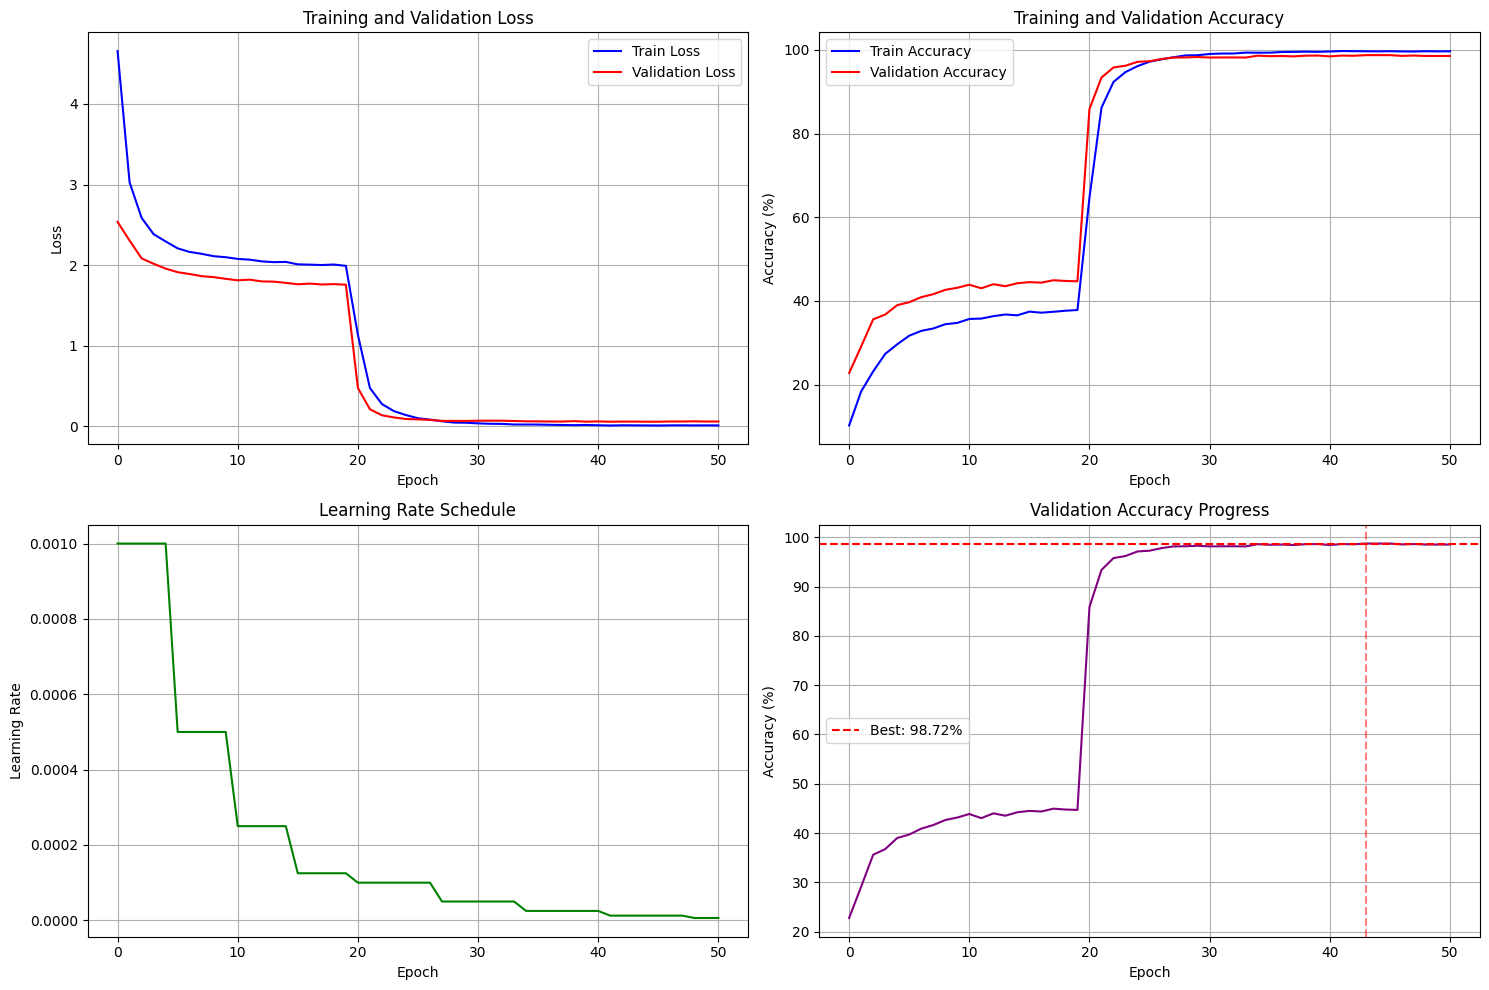

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(training_history['train_loss'], label='Train Loss', color='blue')
axes[0, 0].plot(training_history['val_loss'], label='Validation Loss', color='red')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy
axes[0, 1].plot(training_history['train_acc'], label='Train Accuracy', color='blue')
axes[0, 1].plot(training_history['val_acc'], label='Validation Accuracy', color='red')
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Learning Rate
axes[1, 0].plot(training_history['lr'], color='green')
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].grid(True)

# Accuracy improvement
best_val_acc = max(training_history['val_acc'])
best_epoch = training_history['val_acc'].index(best_val_acc)
axes[1, 1].plot(training_history['val_acc'], color='purple')
axes[1, 1].axhline(y=best_val_acc, color='red', linestyle='--', label=f'Best: {best_val_acc:.2f}%')
axes[1, 1].axvline(x=best_epoch, color='red', linestyle='--', alpha=0.5)
axes[1, 1].set_title('Validation Accuracy Progress')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def evaluate_model(model, valid_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

print("\nДетальная оценка модели...")
val_preds, val_labels = evaluate_model(trained_model, valid_loader, device)


Детальная оценка модели...


Evaluating: 100%|██████████| 63/63 [00:07<00:00,  9.00it/s]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


Отчет по классификации:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       150
           B       0.99      0.97      0.98       176
           C       0.98      0.96      0.97       142
           D       0.99      0.99      0.99       176
           E       0.99      0.99      0.99       153
           F       1.00      1.00      1.00       135
           G       0.98      0.97      0.97       163
           H       0.99      0.97      0.98       181
           I       0.98      0.97      0.97        88
           J       0.97      0.95      0.96        99
           K       0.98      0.99      0.98       159
           L       0.96      1.00      0.98       102
           M       0.98      0.99      0.99       194
           N       0.97      0.98      0.98       184
           O       0.96      0.98      0.97       174
           P       1.00      1.00      1.00       152
           Q       0.98      0.97      0.97       173
  

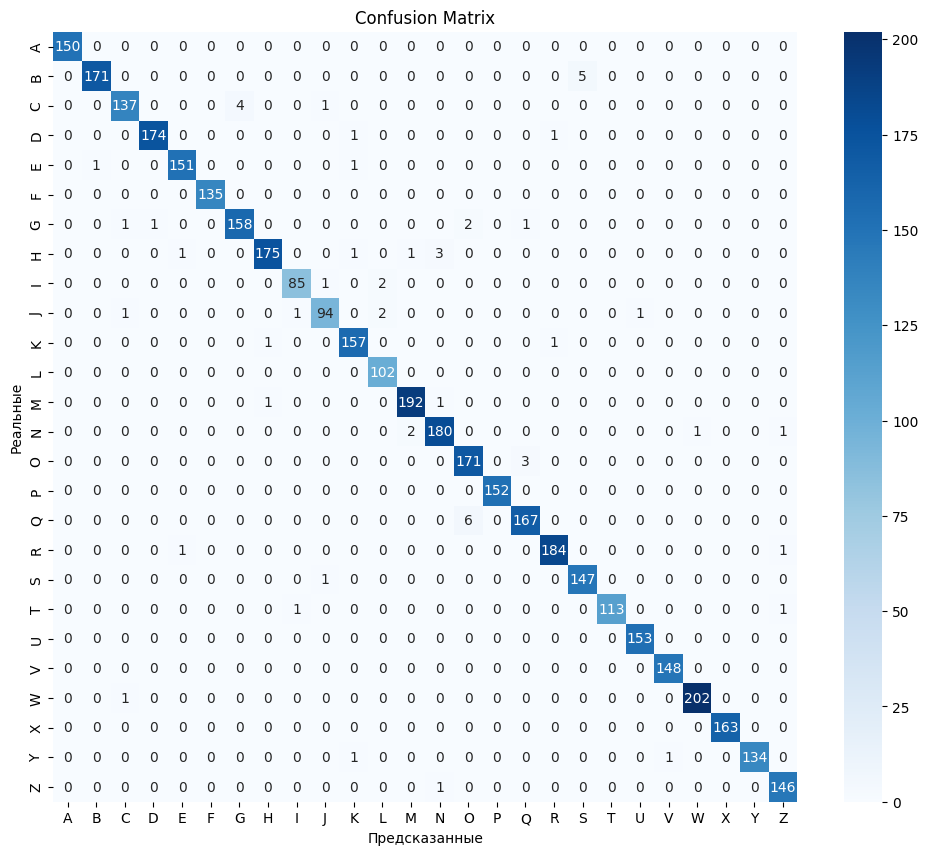

In [ ]:
class_names = [chr(ord('A') + i) for i in range(26)]  # A-Z
report = classification_report(val_labels, val_preds, target_names=class_names, output_dict=True)

print("\nОтчет по классификации:")
print(classification_report(val_labels, val_preds, target_names=class_names))

# Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(val_labels, val_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Предсказанные')
plt.ylabel('Реальные')
plt.show()

### Обучение на полных данных

In [ ]:
def train_model_full(model, train_loader, device, num_epochs_phase1=20, num_epochs_phase2=40):
    criterion = nn.CrossEntropyLoss()

    # История обучения
    history = {
        'train_loss': [], 'train_acc': [],
        'lr': []
    }

    best_acc = 0.0
    best_model_state = None
    patience_counter = 0
    patience = 7

    # ===== ФАЗА 1: Обучение только классификатора =====
    print("\n=== ФАЗА 1: Обучение классификатора ===")

    # Оптимизатор только для классификатора
    classifier_params = [p for p in model.backbone.classifier.parameters() if p.requires_grad]
    print(f"Параметров классификатора для обучения: {sum(p.numel() for p in classifier_params):,}")

    optimizer = optim.Adam(
        classifier_params,
        lr=1e-3,  # Начинаем с разумного LR
        weight_decay=1e-4
    )

    # ПРОСТОЙ scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    for epoch in range(num_epochs_phase1):
        print(f"\nЭпоха {epoch+1}/{num_epochs_phase1}")

        # Текущий learning rate
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Learning Rate: {current_lr:.6f}")

        # Обучение
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)

        # Scheduler step ПОСЛЕ эпохи
        scheduler.step()

        # Сохранение истории
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['lr'].append(current_lr)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")

        # Сохранение лучшей модели
        if train_acc > best_acc:
            best_acc = train_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f"Новая лучшая модель! Точность: {train_acc:.2f}%")
            torch.save(best_model_state, 'best_model_full_phase1.pth')
        else:
            patience_counter += 1
            print(f"Patience: {patience_counter}/{patience}")

            if patience_counter >= patience:
                print("Ранняя остановка в фазе 1!")
                break

    # Загружаем лучшую модель из фазы 1
    model.load_state_dict(best_model_state)

    # ===== ФАЗА 2: Fine-tuning всей модели =====
    print(f"\n=== ФАЗА 2: Fine-tuning всей модели ===")

    # Размораживаем всю модель
    model.unfreeze_for_finetuning()

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Обучаемых параметров после разморозки: {trainable_params:,}")

    # Простой оптимизатор для всех параметров
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

    patience_counter = 0
    for epoch in range(num_epochs_phase2):
        print(f"\nЭпоха {num_epochs_phase1 + epoch + 1}/{num_epochs_phase1 + num_epochs_phase2}")

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Learning Rate: {current_lr:.6f}")

        # Обучение
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)

        scheduler.step()

        # Сохранение истории
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['lr'].append(current_lr)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")

        # Сохранение лучшей модели
        if train_acc > best_acc:
            best_acc = train_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f"Новая лучшая модель! Точность: {val_acc:.2f}%")
            torch.save(best_model_state, 'best_model_full_final.pth')
        else:
            patience_counter += 1
            print(f"Patience: {patience_counter}/{patience}")

            if patience_counter >= patience:
                print("Ранняя остановка в фазе 2!")
                break

    # Загружаем лучшую модель
    model.load_state_dict(best_model_state)

    print(f"\nОбучение завершено! Лучшая точность: {best_acc:.2f}%")

    return model, history, best_acc

In [ ]:
train_img = np.load("/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/images.npy")
labels = np.load("/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/labels.npy")
test_img = np.load("/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/images_sub.npy")

images = torch.tensor(train_img.astype('float32')/255.0).permute(0,3,1,2)
labels = torch.tensor(labels.astype('int64'))
test_images = torch.tensor(test_img.astype('float32')).permute(0,3,1,2)

train_dataset_full = CaptchaDataset(images, labels, transform=train_transform)
test_dataset = CaptchaDataset(test_images, transform=test_transform)

train_loader_full = DataLoader(train_dataset_full, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_f = EfficientNetClassifier(num_classes=26)
model_f = model_f.to(device)

In [ ]:
print("Обучение модели...")
trained_model_f, training_history_f, best_accuracy_f = train_model_full(
    model_f, train_loader_full, device,
    num_epochs_phase1=20,
    num_epochs_phase2=31
)

### Submission

In [ ]:
trained_model_f.eval()
prediction = []

with torch.no_grad():
    for inputs in tqdm(test_loader, desc="Submission"):
        inputs = inputs.to(device)
        outputs = trained_model_f(inputs)
        _, predicted = torch.max(outputs, 1)
        prediction.extend(predicted.cpu().tolist())

In [ ]:
prediction[:10]

In [ ]:
submission = pd.DataFrame({
    'id': np.arange(len(prediction)),
    'Category': prediction
})
submission.to_csv('submission_e_f.csv', index=False)

Наилучший результат продемонстрировал подход с дообучением модели EfficientNet. Удалось достичь значения метрики Accuracy: 0.98574 на public leaderboard соревнования

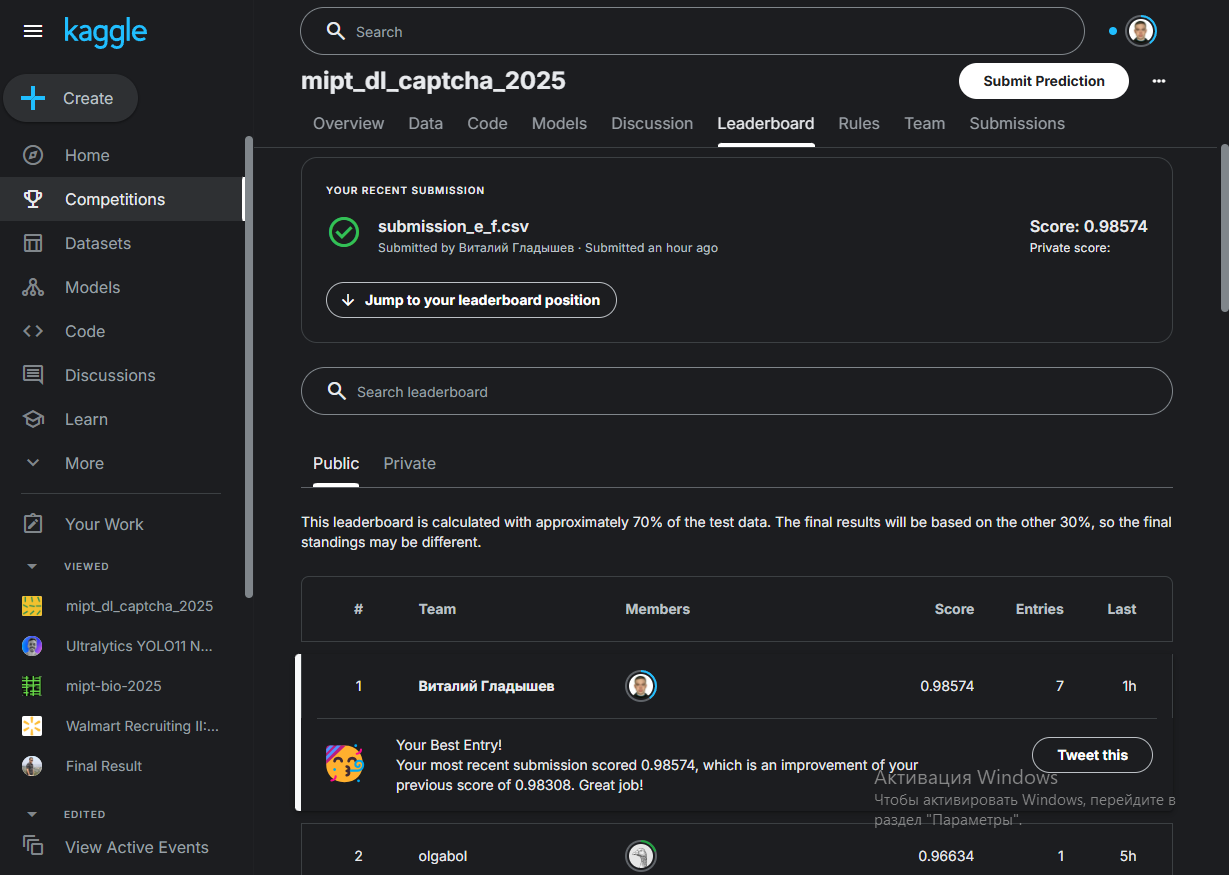